# 0. Making imports

First things first, since I'm using Google Colab to train the model, I have to mount my Google Drive:

In [216]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


And also import all of the libraries I'm going to use:

In [217]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import os
import tarfile
import PIL
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

We'll also disable the warnings (some appear do to the large `num_workers` that we use in our `DataLoader`s):

In [218]:
import warnings
warnings.filterwarnings('ignore')

# 1. The data

## 1.0 Exploring the data

I cloned [this](https://github.com/zysymu/ML4SCI_GSoC) ML4SCI_GSoC github that I forked from the original. I also changed some files around, the `Domain Adaptation` directory contains ML4Sci's evaluation test files, together with the data, the network definition and the pre-trained network weights.

I extract `lenses.tgz` in order to be able to work with the images. The code that does this is commented out because this only needs to happen once.

In [219]:
"""
fname = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/lenses.tgz'
extract_path = '/content/drive/MyDrive/ml4sci/domain_adaptation/'

with tarfile.open(fname, "r:gz") as tar:
    tar.extractall(extract_path)
    tar.close()
"""

'\nfname = \'/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/lenses.tgz\'\nextract_path = \'/content/drive/MyDrive/ml4sci/domain_adaptation/\'\n\nwith tarfile.open(fname, "r:gz") as tar:\n    tar.extractall(extract_path)\n    tar.close()\n'

I then crate a variable that has the path to the directory that contains all lens images:

In [220]:
lens_dir = '/content/drive/MyDrive/ml4sci/domain_adaptation/lenses'

I also plot two random images from each category in order to have a better idea of how they look like:

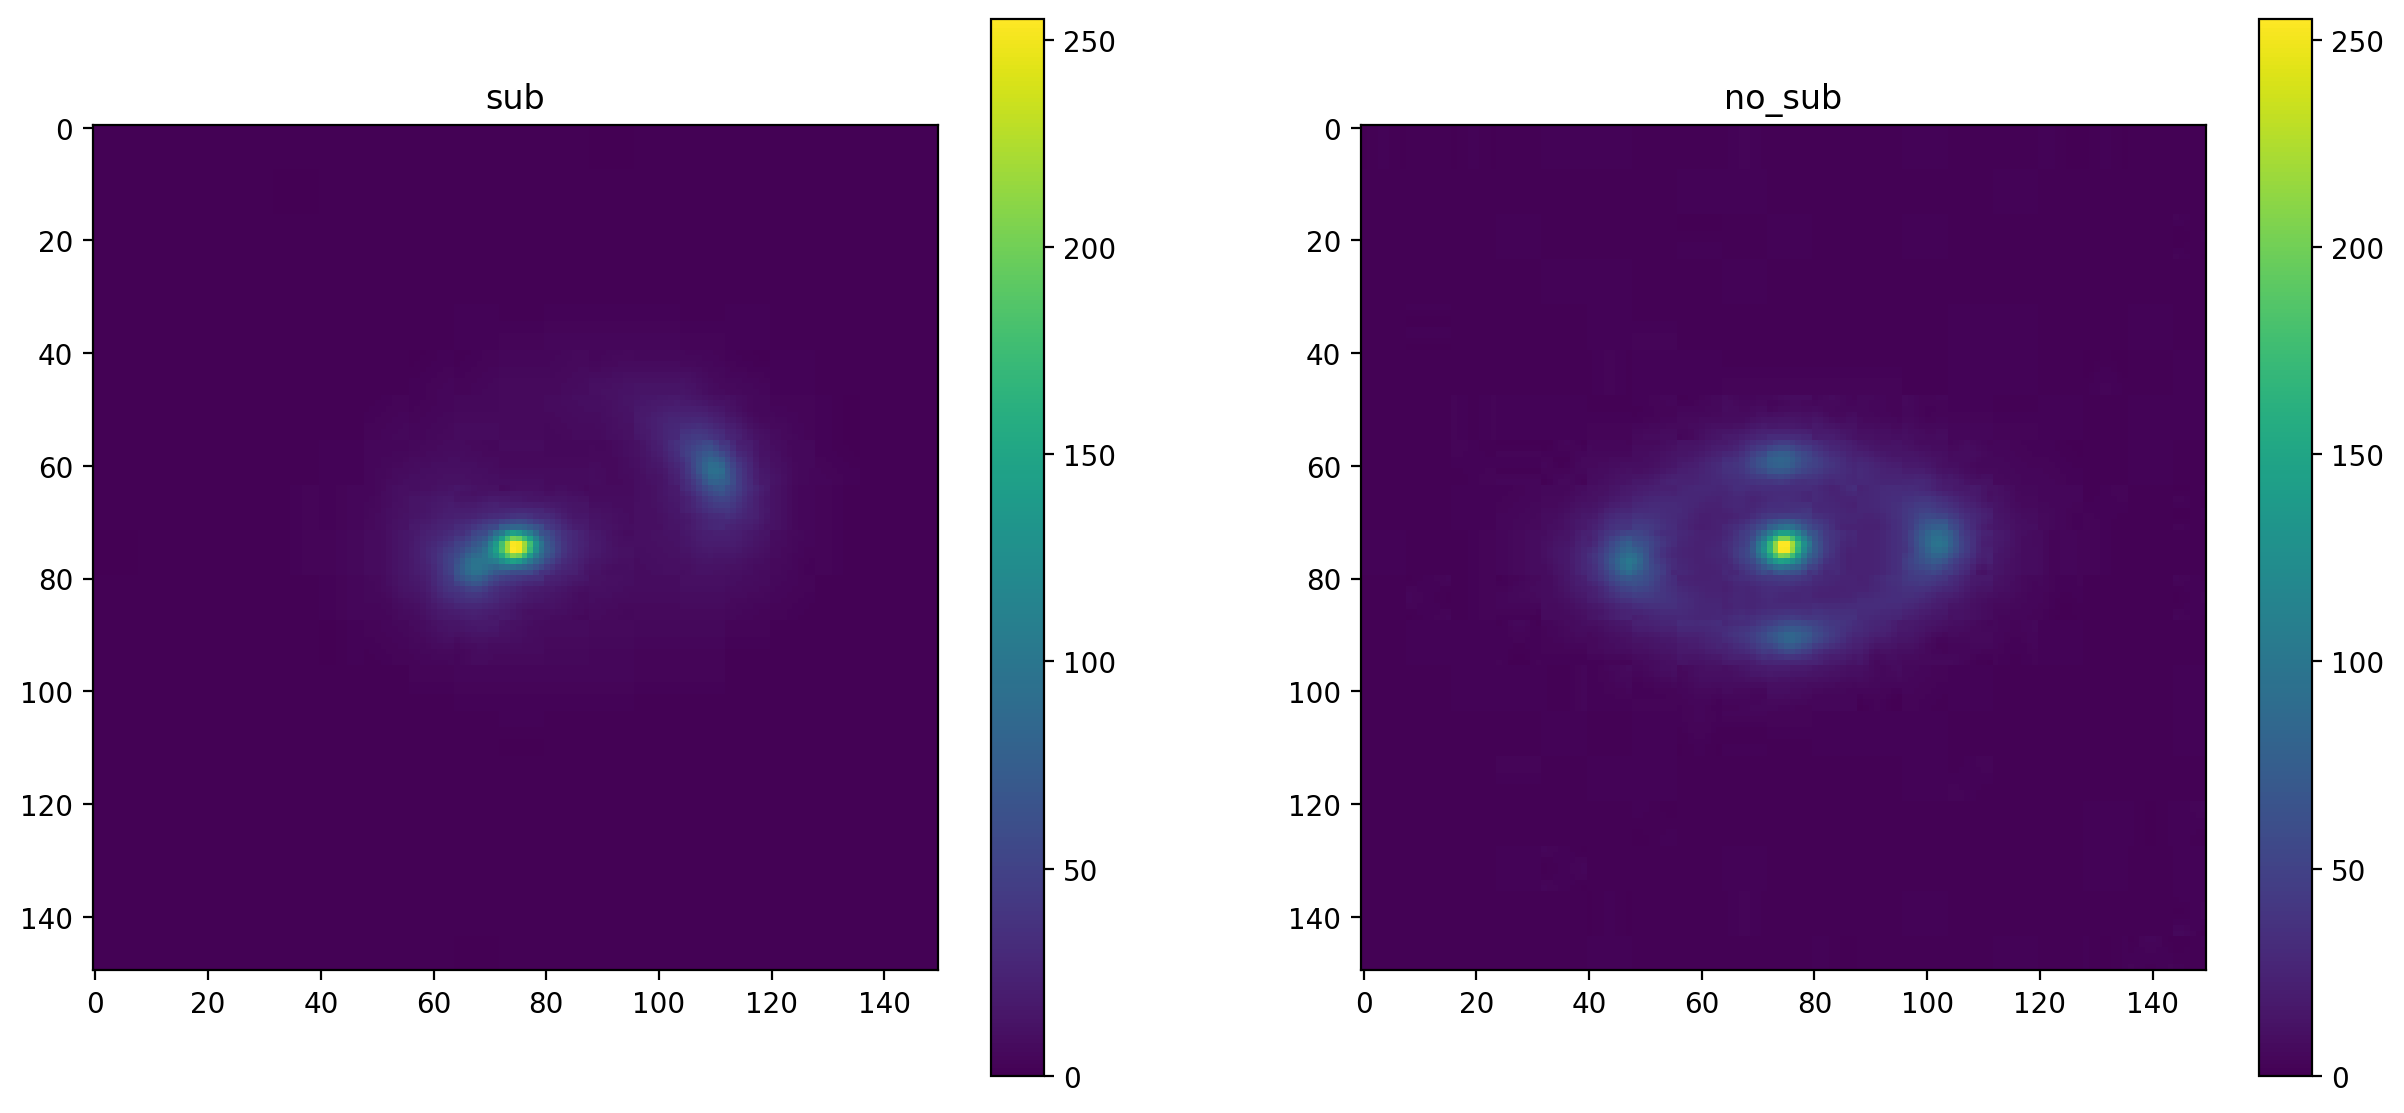

In [221]:
sub_dir = os.path.join(lens_dir, 'sub')
no_sub_dir = os.path.join(lens_dir, 'no_sub')

# pick random images to plot
sub_img = PIL.Image.open(os.path.join(sub_dir,'image_100015241301657914033614173596761104525.jpg'))
no_sub_img = PIL.Image.open(os.path.join(no_sub_dir,'image_97223362218452437755314224058973719256.jpg'))

fig, axs = plt.subplots(1, 2, figsize=(15,7), dpi=200)
im1 = axs[0].imshow(sub_img)
axs[0].set_title('sub')
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(no_sub_img)
axs[1].set_title('no_sub')
plt.colorbar(im2, ax=axs[1])
plt.show()

We can also check some characteristics of the images:

In [222]:
print(sub_img.getextrema())
print(sub_img.size)

(0, 255)
(150, 150)


## 1.1 Creating ways to interact with the data

Now we're concerned with creating a way that'll make it possible for our AAE to retrieve this data and use it for both training and testing (inference).

Since our images are neatly packed in sub-directories, I'll make use of PyTorch's `ImageFolder` to create a dataset that contains all images and their labels:

In [223]:
dataset = ImageFolder(lens_dir)

We can then check how many images are in each category:

In [224]:
np.unique(dataset.targets, return_counts=True)

(array([0, 1]), array([5000, 5000]))

And notice that they're very well distributed!

We can then make a map between the label index and the actual label class:
- `no_sub` = 0
- `sub` = 1

In [225]:
print(dataset.class_to_idx)

{'no_sub': 0, 'sub': 1}


The next step is to create a more elaborate dataset that lets us apply transforms to the data, return individual items and create a `DataLoader` from it:

In [226]:
class LensDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):            
        data = self.transform(dataset[idx][0])
        label = dataset[idx][1]        
        
        return data, label

    def __len__(self):
        return len(self.dataset)

The usage of `LensDataset` makes it really easy to apply transformations to the images. This will let us prepare the images neatly for our AAE while also letting us use data augmentation, something especially useful given the not so large amount of data that we have available.

In the following cell we define the types of transforms that we'll be using:

In [227]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      #transforms.RandomRotation(5),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.Resize((150, 150)),
                                      #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                      transforms.Grayscale(num_output_channels=1)
                                      ])

eval_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((150, 150)),
                                     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                     transforms.Grayscale(num_output_channels=1)
                                     ])

## 1.2 Prepating the data for training/testing

In the evaluation test we were supposed to split the data so that 90% of it was used for training and 10% of it was used for testing. I will follow these proportions in this notebook:

In [228]:
train_dataset = LensDataset(dataset, train_transform)
test_dataset = LensDataset(dataset, eval_transform)

In [229]:
np.random.seed(42) # reproducible results

train_size = 0.9

num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
np.random.shuffle(indices)
train_idx, test_idx = indices[:split], indices[split:]

train_data = Subset(train_dataset, indices=train_idx)
test_data = Subset(test_dataset, indices=test_idx)

We can check if our data was split correctly:

In [230]:
print(len(train_data))
print(len(test_data))

9000
1000


Since we're training an anomaly detector, we want to detect one class as an anomaly. In our case, this will be the `sub` class. If we were to make our dataset be composed of both `sub` and `no_sub`, both would have a similar distribution and we wouldn't be able to tell them apart. This mistake can be seen quite clearly from my original submission [here](https://github.com/zysymu/ml4sci/blob/main/domain_adaptation/domain_adaptation.ipynb).

So in the next step we'll remove the `sub` images from the training dataset:

In [231]:
no_sub_idx = []

for i, (data, label) in enumerate(train_data):
    if label == 0:
        no_sub_idx.append(i)

no_sub_idx = np.array(train_data.indices)[no_sub_idx]
train_data_no_sub = Subset(train_dataset, no_sub_idx)

In [232]:
len(train_data_no_sub)

4519

We still have a good amount of images!

In [233]:
for data, label in train_data_no_sub:
    if label != 0:
        print('NOT OK', label)

We can then create three `DataLoader`s, which will be used for training and testing. The `batch_size` is arbitrarily chosen to be 64:

In [234]:
train_all_dataloader = DataLoader(train_data, shuffle=True, batch_size=1, num_workers=8)
train_no_sub_dataloader = DataLoader(train_data_no_sub, shuffle=True, batch_size=64, num_workers=8)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=1, num_workers=2)

Just to be sure that the data is homogenous across the training and testing samples, we print the first few labels in the `test_dataloader`:

In [235]:
for _, labels in test_dataloader:
    print(labels)
    break

tensor([1])


# 2. The Adversarial Autoencoder (AAE)

## 2.0 Defining the AAE architecture

The structure of the AAE can be seen in the following picture, taken from [here](https://arxiv.org/pdf/1511.05644.pdf):

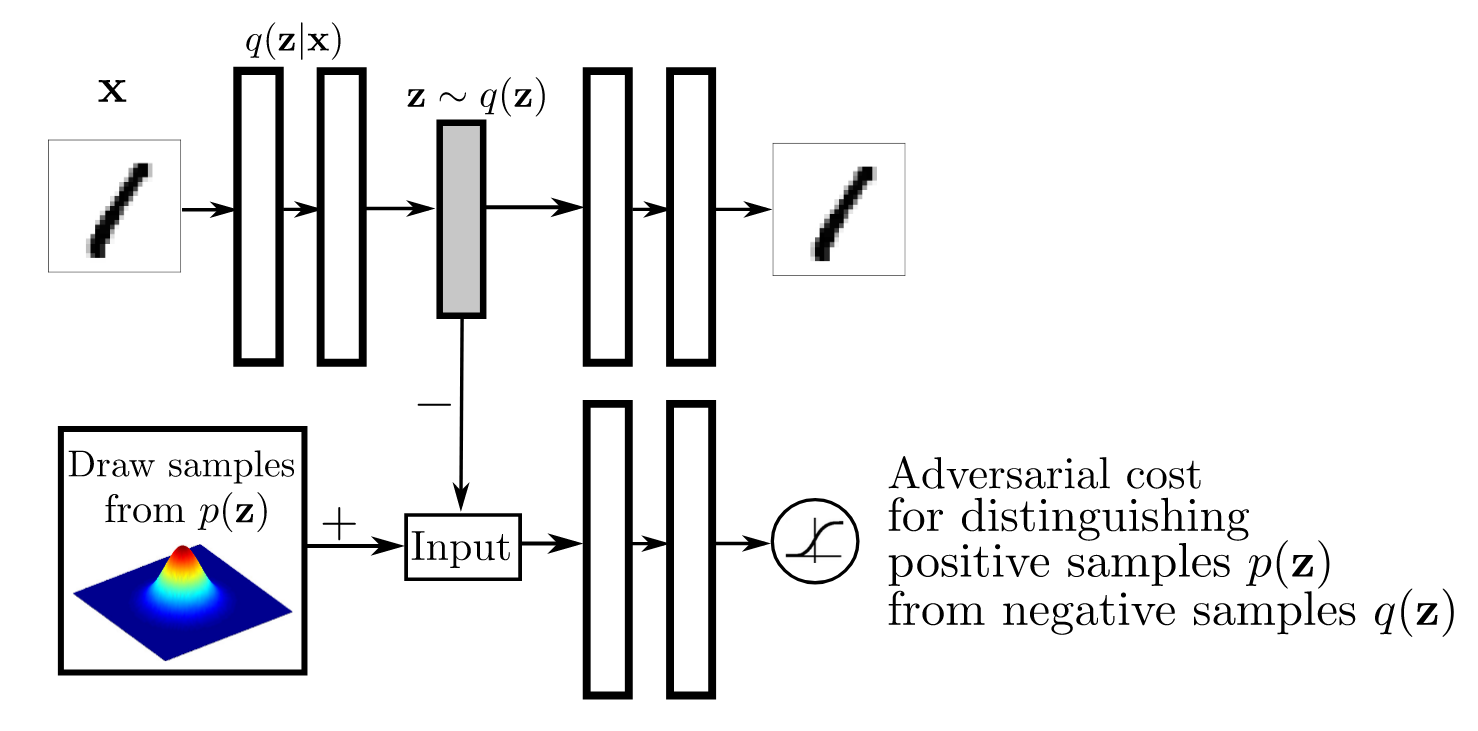



We have three main components: the `Encoder` ($q(z|x)$), the `Decoder` (upper right) and the `Discriminator` (bottom row).

The encoder receives as input an image $x$ and creates a latent representation of it, with smaller dimensions, similar to a compression operation. In our case, the input image $x$ has size 150x150x3, and it is transformed to a latent vector of size 1000x1x1: this is 67.5 times less information than the original image!!!

The decoder's job is to take this latent representation and reconstruct the input. Ideally, this reconstruction would be as close as possible to the input image $x$.

We want to create a latent space that follows a certain distriibution $p(z)$. so that we can generate new inputs without nedding to give the actual images. This makes it possible to "travel" around the latent space, exploring what's between the images that we used for training.

To do this, we make use of the discriminator. It is important to note that if we want to create a distribution for our latent space, we must teach the model to encode images according to this distribution. So we draw samples from our ideal ("real") distribution, which in our case is a simple Gaussian, and compare it with the latent vector of the image. The discriminator identifies which distribution is real and which is fake (random distribution that our encoder generated). From this, we can update the encoder to create vectors that follow our ideal distribution.

We'll be using the AAE as defined by the DeepLense evaluation test, copying the contents of the `AAE_Network_Architecture.py` file. This will enable us to use the pre-trained weights that were given by the evaluation test.

In [236]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 7, stride=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 7, stride=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 7)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(5184, 1000)

    def forward(self, x):
        convolution1 = F.relu(self.conv1(x))
        convolution2 = F.relu(self.conv2(convolution1))
        convolution3 = F.relu(self.conv3(convolution2))
        Flattened = self.flat(convolution3)
        z = self.linear(Flattened)

        return z

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Linear(1000, 5184)
        self.conv4 = nn.ConvTranspose2d(64, 32, 7)
        self.conv5 = nn.ConvTranspose2d(32, 16, 7, stride=3, padding=1, output_padding=2)
        self.conv6 = nn.ConvTranspose2d(16, 1, 6, stride=3, padding=1, output_padding=2)

    def forward(self, x):
        hidden = self.linear(x)
        Reshaped = hidden.reshape(-1,64,9,9)
        convolution4 = F.relu(self.conv4(Reshaped))
        convolution5 = F.relu(self.conv5(convolution4))
        predicted = torch.tanh(self.conv6(convolution5))

        return predicted

class Discriminator(nn.Module):
    def __init__(self, dim_z=1000 , dim_h=256):
        super(Discriminator,self).__init__()
        
        self.dim_z = dim_z
        self.dim_h = dim_h
        self.network = []
        self.network.extend([
            nn.Linear(self.dim_z, self.dim_h),
            nn.ReLU(),
            nn.Linear(self.dim_h, self.dim_h),
            nn.ReLU(),
            nn.Linear(self.dim_h,1),
            nn.Sigmoid(),
        ])
        self.network = nn.Sequential(*self.network)

    def forward(self, z):
        disc = self.network(z)

        return disc

The distribution that we want our AAE to follow is arbitrary and it's definetely worth checking out different distributions in order to find the best one for the problem at hand. For simplicity sake we're going to use a simple gaussian distribution that can be seen in many different AAE implementations:

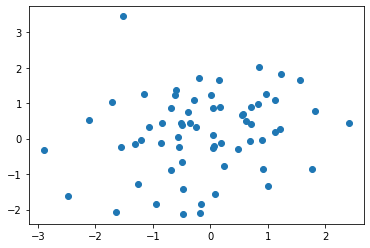

In [237]:
z_distribution = torch.randn(64, 1000)
plt.scatter(z_distribution[:,0], z_distribution[:,1])
plt.show()

Here $64$ represents the batch size, which is a hyperparameter and $1000$ is the size of our latent vector. This is made more easily understandable while looking at the training loops.

## 2.1 Creating a way to load the model

We'll start off by defining the device that we'll use:

In [238]:
global device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

We can then create a function that loads the model:

In [239]:
def load_model():
    """
    Loads the model
    """
    encoder = Encoder()
    decoder = Decoder()
    discriminator = Discriminator()

    encoder = encoder.to(device)
    decoder = decoder.to(device)
    discriminator = discriminator.to(device)

    return encoder, decoder, discriminator

We'll also define a function that enables us to load the pre-trained model:

In [240]:
def load_model_pretrained(encoder_model, decoder_model, discriminator_model):
    """
    Loads the model by being given the path to the architecture + weights of each network
    """
    encoder = Encoder()
    decoder = Decoder()
    discriminator = Discriminator()

    encoder = torch.load(encoder_model, map_location=device)
    decoder = torch.load(decoder_model, map_location=device)
    discriminator = torch.load(discriminator_model, map_location=device)

    encoder = encoder.to(device)
    decoder = decoder.to(device)
    discriminator = discriminator.to(device)

    return encoder, decoder, discriminator

Finally, we'll also define a function that enables us to load the model (using `state_dict`s, the recommended way of saving model weights in PyTorch) and its history:

In [241]:
def load_weights_and_history(save_path):
    """
    Loads the model weights and history
    """
    s = torch.load(save_path, map_location=device)

    history = s['history']

    encoder = Encoder()
    decoder = Decoder()
    discriminator = Discriminator()

    encoder.load_state_dict(s['encoder_weights'])
    decoder.load_state_dict(s['decoder_weights'])
    discriminator.load_state_dict(s['discriminator_weights'])

    encoder = encoder.to(device)
    decoder = decoder.to(device)
    discriminator = discriminator.to(device)

    return encoder, decoder, discriminator, history

## 2.2 Creating the training loop

Now that we can access the model, we'll define a function that enables us to train it:

In [242]:
def train_model(encoder, decoder, discriminator, train_dataloader, epochs, save_path, viz=False):
    """
    Train the AAE.

    Inputs:
    -------
    encoder: the encoder model.
    
    decoder: the decoder model.
    
    discriminator: the discriminator model.

    train_dataloader: a `DataLoader` based on a `LensDataset`.

    epochs: number of epochs to train on (int).

    save_path: path to save the model's weights and history (str).

    viz: if `True`, after each epoch a original image - reconstructed image pair will be plotted
    """
    # --- HYPERPARAMETERS --- (these could be function arguments, but for simplicity sake we'll make them fixed)
    # reconstruction phase:
    reconstruction_criterion = nn.MSELoss()
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4)

    # regularization phase:
    def discriminator_criterion(input, target, epsilon):
        return -torch.mean(torch.log(target + epsilon) + torch.log(1 - input + epsilon))

    def generator_criterion(input, epsilon):
        return -torch.mean(torch.log(input + epsilon))

    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)
    generator_optimizer = optim.Adam(encoder.parameters(), lr=1e-5)

    # set learning rate schedulers (a more thorough analysis of this would be really useful!)
    # as of now i'm using default parameters to all optimizers
    encoder_scheduler = lr_scheduler.StepLR(encoder_optimizer, step_size=7, gamma=0.1)
    decoder_scheduler = lr_scheduler.StepLR(decoder_optimizer, step_size=7, gamma=0.1)
    discriminator_scheduler = lr_scheduler.StepLR(discriminator_optimizer, step_size=7, gamma=0.1)
    generator_scheduler = lr_scheduler.StepLR(generator_optimizer, step_size=7, gamma=0.1)

    # --- HISOTRY ---
    history = {'reconstruction_losses': [],
                'discriminator_losses': [],
                'generator_losses': []}

    # --- TRAINING LOOP ---
    epsilon = 1e-10 # prevents the loss from getting to zero

    reconstruction_losses = []
    discriminator_losses = []
    generator_losses = []

    for epoch in range(epochs):
        decoder.train()
        encoder.train()
        discriminator.train()

        running_reconstruction_loss = 0.0
        running_discriminator_loss = 0.0
        running_generator_loss = 0.0

        loop = tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=True)
        for data, label in loop:
            data = data.to(device)

            # zero the gradients
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            discriminator_optimizer.zero_grad()
            generator_optimizer.zero_grad()

            # RECONSTRUCTION PHASE
            # pass data through the autoencoder
            z_sample = encoder(data)
            x_sample = decoder(z_sample)

            # compute the loss
            reconstruction_loss = reconstruction_criterion(input=x_sample, target=data)
                
            # backpropagate and update weights
            reconstruction_loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()

            # REGULARIZATION PHASE - DISCRIMINATOR
            encoder.eval()
                
            # generate target latent space data according to a gaussian distribution
            z_real_gauss = Variable(torch.randn(data.size(0), 1000)) # 1000 fixed cuz its the encoder's input size
            z_real_gauss = z_real_gauss.to(device) # what we want
            z_fake_gauss = encoder(data) # what we currently have

            # determine discriminator classification of both samples
            d_real_gauss = discriminator(z_real_gauss) # real sampled gaussian 
            d_fake_gauss = discriminator(z_fake_gauss) # fake created gaussian

            # compute the loss
            discriminator_loss = discriminator_criterion(input=d_fake_gauss, target=d_real_gauss, epsilon=epsilon)
                
            # backpropagate and update weights
            discriminator_loss.backward()
            discriminator_optimizer.step()

            # REGULARIZATION PHASE - GENERATOR
            encoder.train()

            z_fake_gauss = encoder(data)
            d_fake_gauss = discriminator(z_fake_gauss)
                
            # compute the loss
            generator_loss = generator_criterion(input=d_fake_gauss, epsilon=epsilon)

            # backpropagate and update weights
            generator_loss.backward()
            generator_optimizer.step()

            # METRICS
            running_reconstruction_loss += reconstruction_loss.item()# * data.size(0)
            running_discriminator_loss += discriminator_loss.item()# * data.size(0)
            running_generator_loss += generator_loss.item()# * data.size(0)

            loop.set_description(f'Epoch {epoch+1}/{epochs}')

        # save metrics
        epoch_reconstruction_loss = running_reconstruction_loss / len(train_dataloader.dataset)
        epoch_discriminator_loss = running_discriminator_loss / len(train_dataloader.dataset)
        epoch_generator_loss = running_generator_loss / len(train_dataloader.dataset)

        reconstruction_losses.append(epoch_reconstruction_loss)
        discriminator_losses.append(epoch_discriminator_loss)
        generator_losses.append(epoch_generator_loss)

        # visualize the reconstruction
        if viz:
            fig, axs = plt.subplots(1,2)
            axs[0].imshow(data[0,0].detach().cpu().numpy())
            axs[1].imshow(x_sample[0,0].detach().cpu().numpy())
            plt.show()

        print(f'\n[Epoch {epoch+1}/{epochs}]', 'reconstruction loss: {:.4f}; discriminator loss: {:.4f}; generator loss: {:.4f}'.format(epoch_reconstruction_loss, epoch_discriminator_loss, epoch_generator_loss))

        # learning rate scheduler
        encoder_scheduler.step()
        decoder_scheduler.step()
        discriminator_scheduler.step()
        generator_scheduler.step()

    history['reconstruction_losses'] = reconstruction_losses
    history['discriminator_losses'] = discriminator_losses
    history['generator_losses'] = generator_losses

    torch.save({'encoder_weights': encoder.state_dict(),
                'decoder_weights': decoder.state_dict(),
                'discriminator_weights': discriminator.state_dict(),
                'history': history}, save_path)
        
    return encoder, decoder, discriminator, history

## 2.3 Defining a way to visualize the metrics

We'll define a function that enables us to visualize the model's training metrics:

In [243]:
def metrics(history):
    """
    Plot the three metrics that are tracked during training.
    """
    fig, axs = plt.subplots(1, 3, figsize=(18,5), dpi=200)

    epochs = len(history['reconstruction_losses'])

    axs[0].plot(range(1, epochs+1), history['reconstruction_losses'])
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Reconstruction loss')
    axs[0].set_title('Reconstruction loss')

    axs[1].plot(range(1, epochs+1), history['discriminator_losses'])
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Discriminator loss')
    axs[1].set_title('Discriminator loss')

    axs[2].plot(range(1, epochs+1), history['generator_losses'])
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Generator loss')
    axs[2].set_title('Generator loss')      
        
    plt.show()

## 2.4 Defining a way to evaluate the model

The method that we'll use to evaluate the model was inspired heavily by [this](https://arxiv.org/pdf/1902.06924.pdf) paper. I apply a simple mean squared error comparing the original image to the generated one. This outputs an anomaly score. If the anomaly score is above a certain threshold, the image is considered an anomaly (`sub`).

It is important to note that in the paper the authors mention applying the discriminator on the encoded data and using its output as an anomaly score. I didn't apply this method because it didn't seem to output good results for me, but more systematic tests could check if this is indeed the case.

First we must find a good value for the threshold. In my original submission I found a value from the test set. This would **not** be very useful in a real life situation. For this reason, we'll use the training set to find this threshold. This makes sure that we don't influence our classifier with the test data:

In [274]:
def find_thresh(encoder, decoder, discriminator, train_dataloader, viz=False):
    encoder.eval()
    decoder.eval()

    anomaly_scores = {0:[], 1:[]}
    mse = nn.MSELoss()

    print('\nfinding anomaly_scores statistics...')
    loop = tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=True)
    for data, label in loop:
        data = data.to(device)

        encoded = encoder(data)
        decoded = decoder(encoded)

        for i in range (data.shape[0]):
            anomaly_score = mse(data[0], decoded[0])

            if label[i] == 0:
                anomaly_scores[0].append(anomaly_score.item())
            else:
                anomaly_scores[1].append(anomaly_score.item())

    anomaly_list = list(anomaly_scores.values())
    anomaly_list = [item for sublist in anomaly_list for item in sublist]
    thresh = np.mean(anomaly_list)

    if viz == True:
        plt.figure(figsize=(7,7), dpi=200)
        plt.hist(anomaly_scores[0], bins='auto', color='b', alpha=.5, label='0')
        plt.hist(anomaly_scores[1], bins='auto', color='r', alpha=.5, label='1')
        plt.axvline(thresh, linestyle='--', c='black', label='thresh')
        plt.legend()
        plt.show()

    return thresh

Now we'll define a function that enables us to compare the labels assigned to images by the model with the images real labels. This lets us see how accurate the model was:

In [275]:
def evaluate(encoder, decoder, discriminator, test_dataloader, thresh):
    """
    Use the AAE for inference over the `test_dataloader` data. A label is assigned 
    depending on whether the anomaly_score, defined as the error between the original
    image and its reconstruction, is above or below `thresh`.

    Inputs:
    -------
    test_dataloader: a `DataLoader` based on a `LensDataset`

    thresh: a number that defines the label of an input image according to the error
    between the original image and its reconstruction. If error > thresh, label = 1; 
    if error <= thresh, label = 0 (float)
    """
    encoder.eval()
    decoder.eval()

    mse = nn.MSELoss()
    true_labels = []
    predictions = []
        
    loop = tqdm(test_dataloader, total=len(test_dataloader), position=0, leave=True)
    for data, label in loop:
        data = data.to(device)
        label = label.to(device)

        encoded = encoder(data)
        decoded = decoder(encoded)

        for i in range (data.shape[0]):
            anomaly_score = mse(data[0], decoded[0])

            pred = int(anomaly_score > thresh)

            true_labels.append(label[i].item())
            predictions.append(pred)

    # plot the ROC
    plt.figure(figsize=(7,7), dpi=200)
    fp, tp, _ = roc_curve(true_labels, predictions)
    auroc = auc(fp, tp)

    auroc = float('{:.2f}'.format(auroc))
    n = f'auroc = {auroc}'

    plt.plot(fp, tp, label=n)
    plt.xlabel('False Positives')
    plt.ylabel('True Positives')
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.legend()
    plt.show()

    # plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['({0:.2%})'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    tn, fp, fn, tp = cm.ravel()

    plt.figure(figsize=(7,7), dpi=200)
    sns.heatmap(cm, annot=labels, fmt="")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

# 3. Training the AAE from scratch

## 3.0 Training the model 

We can first visualize how the model is performing without any training. To do this we'll load the model:

In [246]:
encoder_scratch, decoder_scratch, discriminator_scratch = load_model()

And try to reconstruct a random image: (left: original image; right: reconstructed image)

tensor(0)


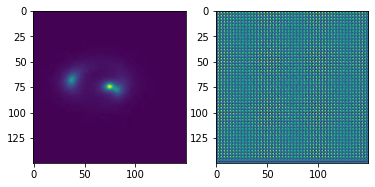

In [247]:
for data, label in train_no_sub_dataloader:
    data = data.to(device)

    z_sample = encoder_scratch(data)
    x_sample = decoder_scratch(z_sample)

    print(label[0])
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(data[0,0].detach().cpu().numpy())
    axs[1].imshow(x_sample[0,0].detach().cpu().numpy())
    plt.show()
    
    break

We'll then train the AAE from the scratch (i.e. not using the pre-trained weights). We'll also be enabling `viz` in order to see the progress of the reconstruction:

Epoch 1/100: 100%|██████████| 71/71 [00:17<00:00,  3.98it/s]


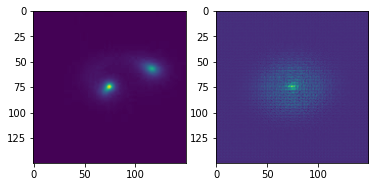

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 1/100] reconstruction loss: 0.0000; discriminator loss: 0.0149; generator loss: 0.0158


Epoch 2/100: 100%|██████████| 71/71 [00:17<00:00,  4.04it/s]


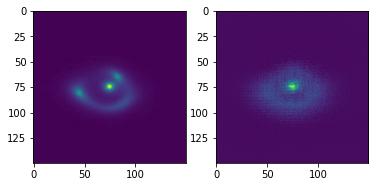

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 2/100] reconstruction loss: 0.0000; discriminator loss: 0.0034; generator loss: 0.0432


Epoch 3/100: 100%|██████████| 71/71 [00:17<00:00,  3.95it/s]


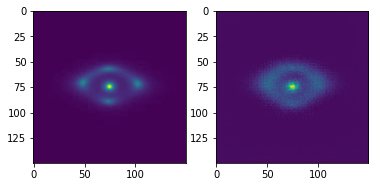

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 3/100] reconstruction loss: 0.0000; discriminator loss: 0.0010; generator loss: 0.0595


Epoch 4/100: 100%|██████████| 71/71 [00:17<00:00,  3.95it/s]


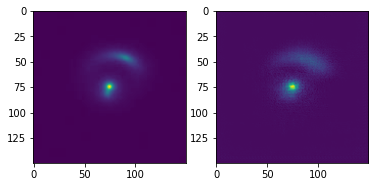

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 4/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.0682


Epoch 5/100: 100%|██████████| 71/71 [00:18<00:00,  3.92it/s]


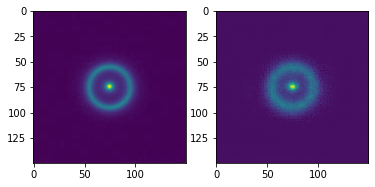

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 5/100] reconstruction loss: 0.0000; discriminator loss: 0.0003; generator loss: 0.0760


Epoch 6/100: 100%|██████████| 71/71 [00:18<00:00,  3.92it/s]


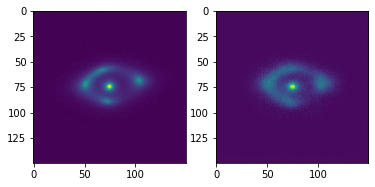

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 6/100] reconstruction loss: 0.0000; discriminator loss: 0.0002; generator loss: 0.0818


Epoch 7/100: 100%|██████████| 71/71 [00:18<00:00,  3.94it/s]


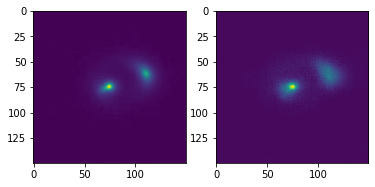

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 7/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0871


Epoch 8/100: 100%|██████████| 71/71 [00:17<00:00,  3.96it/s]


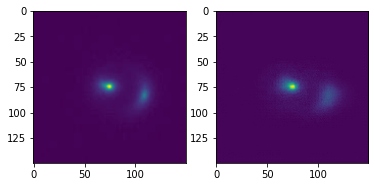

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 8/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0844


Epoch 9/100: 100%|██████████| 71/71 [00:18<00:00,  3.85it/s]


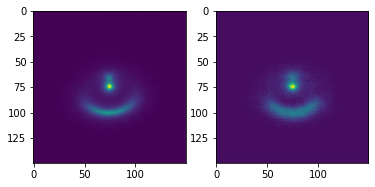

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 9/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0880


Epoch 10/100: 100%|██████████| 71/71 [00:17<00:00,  3.95it/s]


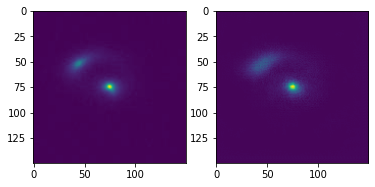

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 10/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0909


Epoch 11/100: 100%|██████████| 71/71 [00:18<00:00,  3.92it/s]


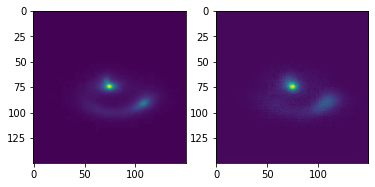

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 11/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0931


Epoch 12/100: 100%|██████████| 71/71 [00:17<00:00,  4.00it/s]


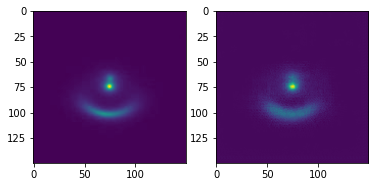

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 12/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0953


Epoch 13/100: 100%|██████████| 71/71 [00:18<00:00,  3.89it/s]


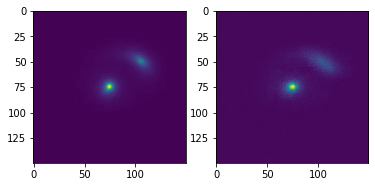

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 13/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0973


Epoch 14/100: 100%|██████████| 71/71 [00:18<00:00,  3.90it/s]


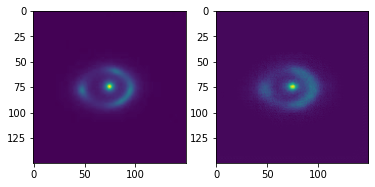

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 14/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0992


Epoch 15/100: 100%|██████████| 71/71 [00:18<00:00,  3.85it/s]


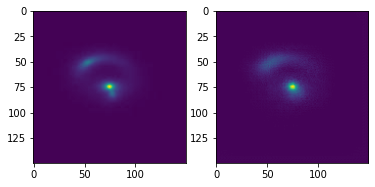

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 15/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0997


Epoch 16/100: 100%|██████████| 71/71 [00:18<00:00,  3.92it/s]


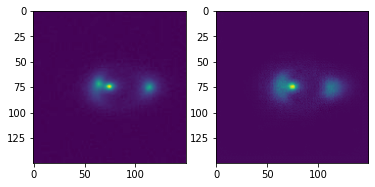

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 16/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0999


Epoch 17/100: 100%|██████████| 71/71 [00:18<00:00,  3.84it/s]


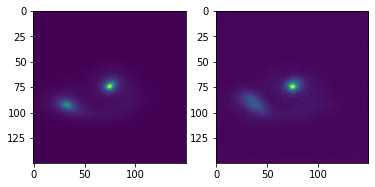

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 17/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1003


Epoch 18/100: 100%|██████████| 71/71 [00:18<00:00,  3.85it/s]


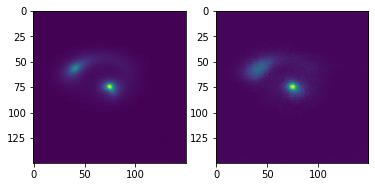

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 18/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1007


Epoch 19/100: 100%|██████████| 71/71 [00:18<00:00,  3.87it/s]


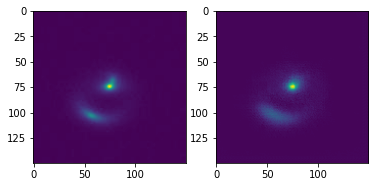

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 19/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1010


Epoch 20/100: 100%|██████████| 71/71 [00:18<00:00,  3.91it/s]


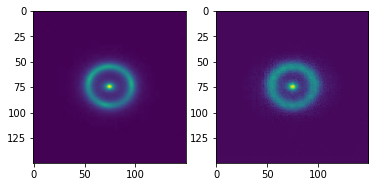

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 20/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1016


Epoch 21/100: 100%|██████████| 71/71 [00:18<00:00,  3.92it/s]


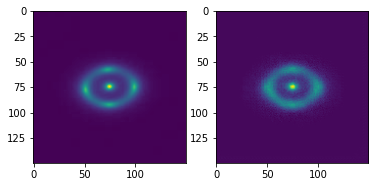

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 21/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1020


Epoch 22/100: 100%|██████████| 71/71 [00:18<00:00,  3.85it/s]


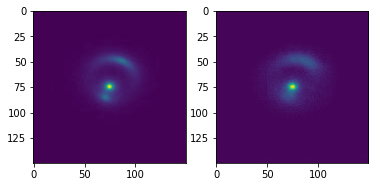

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 22/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1022


Epoch 23/100: 100%|██████████| 71/71 [00:18<00:00,  3.83it/s]


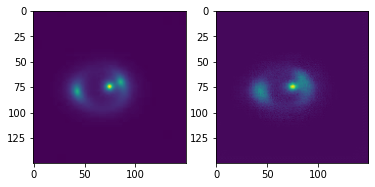

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 23/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1023


Epoch 24/100: 100%|██████████| 71/71 [00:18<00:00,  3.89it/s]


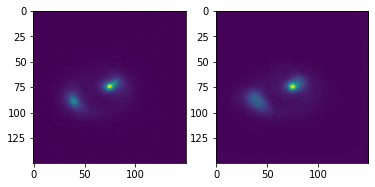

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 24/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1024


Epoch 25/100: 100%|██████████| 71/71 [00:18<00:00,  3.83it/s]


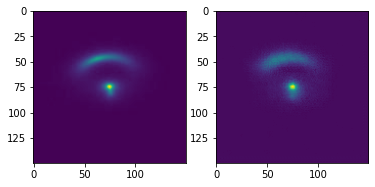

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 25/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1024


Epoch 26/100: 100%|██████████| 71/71 [00:18<00:00,  3.89it/s]


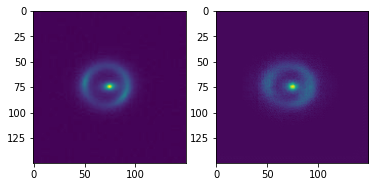

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 26/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1026


Epoch 27/100: 100%|██████████| 71/71 [00:18<00:00,  3.89it/s]


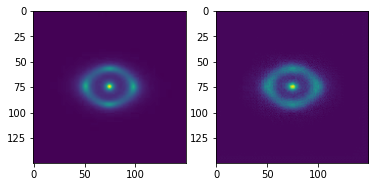

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 27/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1027


Epoch 28/100: 100%|██████████| 71/71 [00:18<00:00,  3.84it/s]


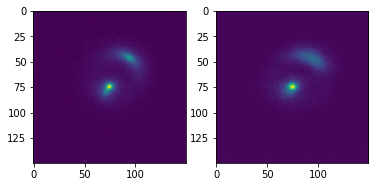

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 28/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1027


Epoch 29/100: 100%|██████████| 71/71 [00:18<00:00,  3.83it/s]


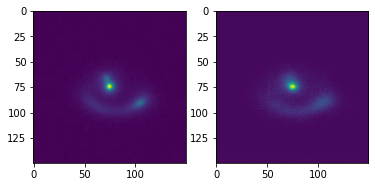

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 29/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 30/100: 100%|██████████| 71/71 [00:18<00:00,  3.75it/s]


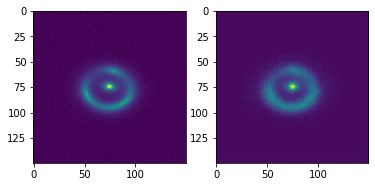

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 30/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 31/100: 100%|██████████| 71/71 [00:18<00:00,  3.80it/s]


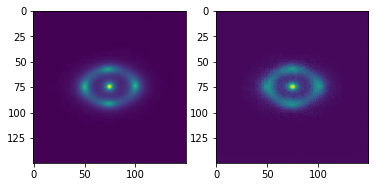

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 31/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 32/100: 100%|██████████| 71/71 [00:18<00:00,  3.82it/s]


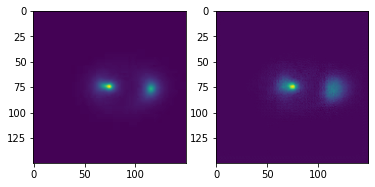

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 32/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 33/100: 100%|██████████| 71/71 [00:18<00:00,  3.79it/s]


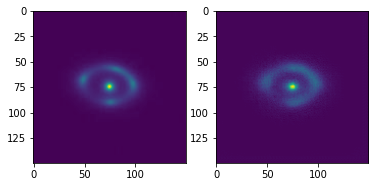

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 33/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 34/100: 100%|██████████| 71/71 [00:18<00:00,  3.81it/s]


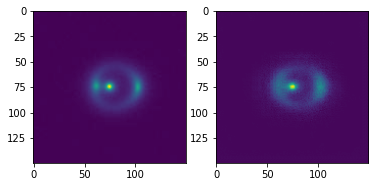

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 34/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 35/100: 100%|██████████| 71/71 [00:18<00:00,  3.74it/s]


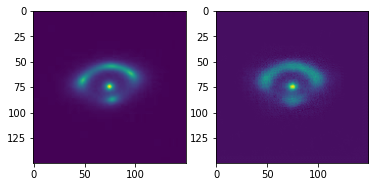

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 35/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 36/100: 100%|██████████| 71/71 [00:18<00:00,  3.80it/s]


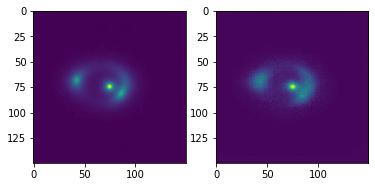

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 36/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 37/100: 100%|██████████| 71/71 [00:18<00:00,  3.81it/s]


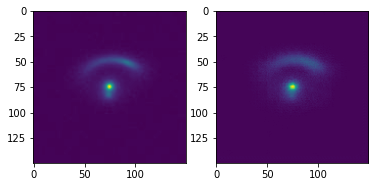

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 37/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 38/100: 100%|██████████| 71/71 [00:18<00:00,  3.81it/s]


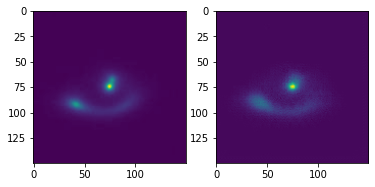

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 38/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 39/100: 100%|██████████| 71/71 [00:19<00:00,  3.70it/s]


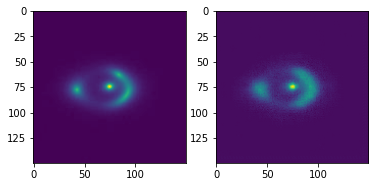

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 39/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 40/100: 100%|██████████| 71/71 [00:18<00:00,  3.81it/s]


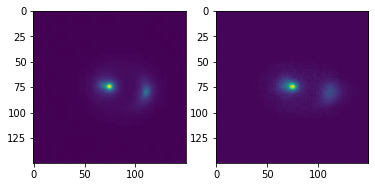

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 40/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 41/100: 100%|██████████| 71/71 [00:18<00:00,  3.79it/s]


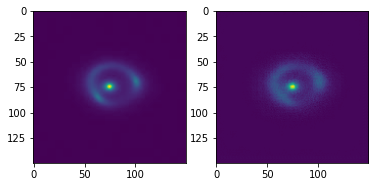

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 41/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 42/100: 100%|██████████| 71/71 [00:18<00:00,  3.77it/s]


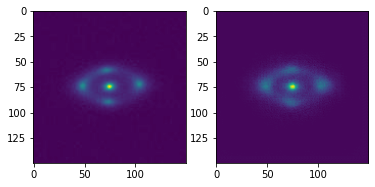

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 42/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 43/100: 100%|██████████| 71/71 [00:19<00:00,  3.71it/s]


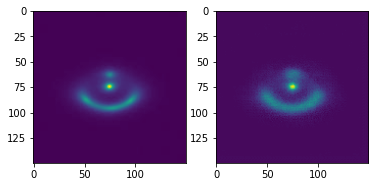

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 43/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 44/100: 100%|██████████| 71/71 [00:19<00:00,  3.73it/s]


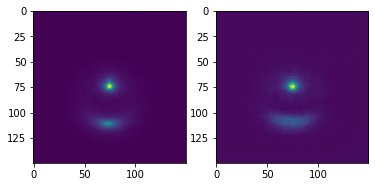

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 44/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 45/100: 100%|██████████| 71/71 [00:18<00:00,  3.76it/s]


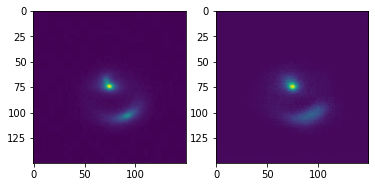

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 45/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 46/100: 100%|██████████| 71/71 [00:19<00:00,  3.70it/s]


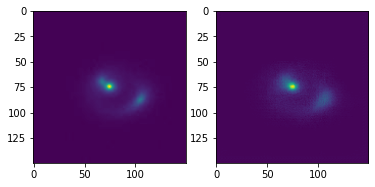

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 46/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 47/100: 100%|██████████| 71/71 [00:19<00:00,  3.71it/s]


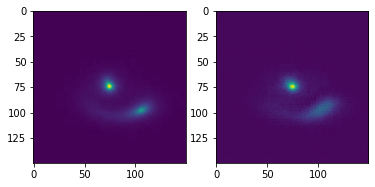

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 47/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 48/100: 100%|██████████| 71/71 [00:18<00:00,  3.75it/s]


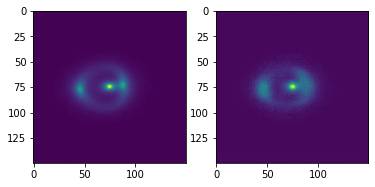

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 48/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 49/100: 100%|██████████| 71/71 [00:19<00:00,  3.73it/s]


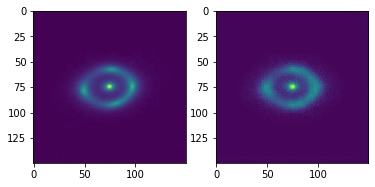

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 49/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 50/100: 100%|██████████| 71/71 [00:19<00:00,  3.72it/s]


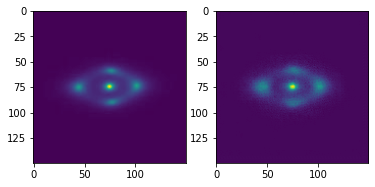

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 50/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 51/100: 100%|██████████| 71/71 [00:19<00:00,  3.73it/s]


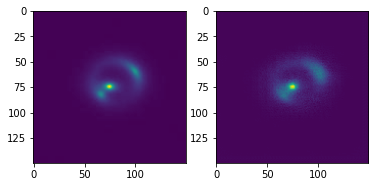

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 51/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 52/100: 100%|██████████| 71/71 [00:19<00:00,  3.66it/s]


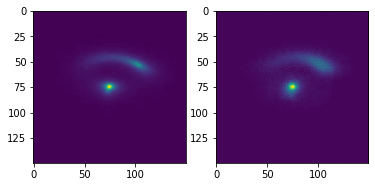

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 52/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 53/100: 100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


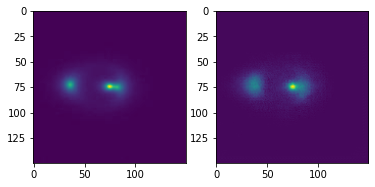

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 53/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 54/100: 100%|██████████| 71/71 [00:19<00:00,  3.69it/s]


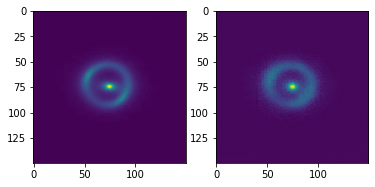

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 54/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 55/100: 100%|██████████| 71/71 [00:19<00:00,  3.69it/s]


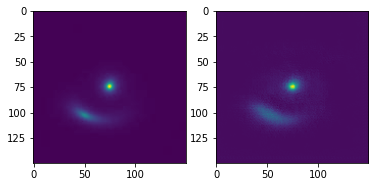

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 55/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 56/100: 100%|██████████| 71/71 [00:19<00:00,  3.70it/s]


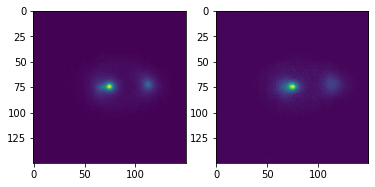

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 56/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 57/100: 100%|██████████| 71/71 [00:19<00:00,  3.68it/s]


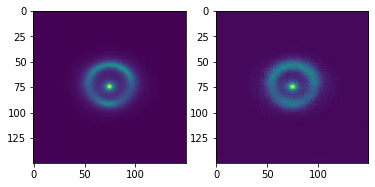

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 57/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 58/100: 100%|██████████| 71/71 [00:19<00:00,  3.62it/s]


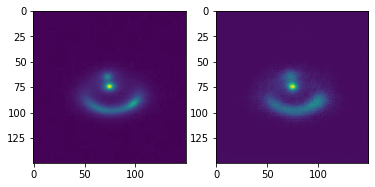

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 58/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 59/100: 100%|██████████| 71/71 [00:19<00:00,  3.70it/s]


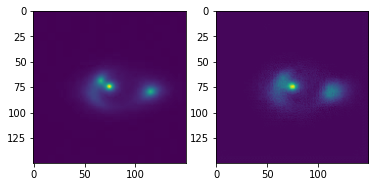

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 59/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 60/100: 100%|██████████| 71/71 [00:19<00:00,  3.63it/s]


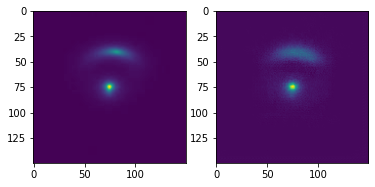

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 60/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 61/100: 100%|██████████| 71/71 [00:19<00:00,  3.69it/s]


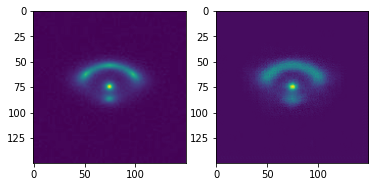

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 61/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 62/100: 100%|██████████| 71/71 [00:19<00:00,  3.63it/s]


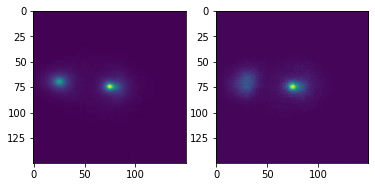

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 62/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 63/100: 100%|██████████| 71/71 [00:19<00:00,  3.60it/s]


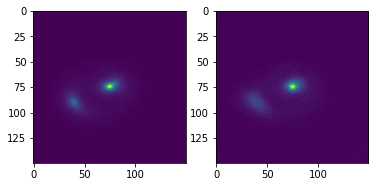

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 63/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 64/100: 100%|██████████| 71/71 [00:19<00:00,  3.66it/s]


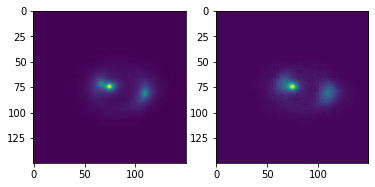

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 64/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 65/100: 100%|██████████| 71/71 [00:19<00:00,  3.61it/s]


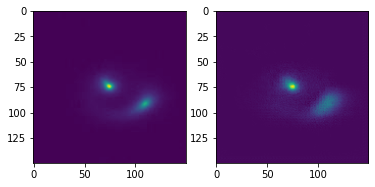

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 65/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 66/100: 100%|██████████| 71/71 [00:19<00:00,  3.63it/s]


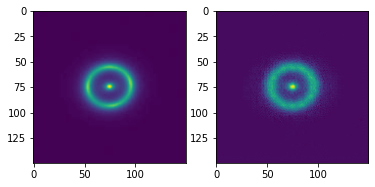

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 66/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 67/100: 100%|██████████| 71/71 [00:19<00:00,  3.69it/s]


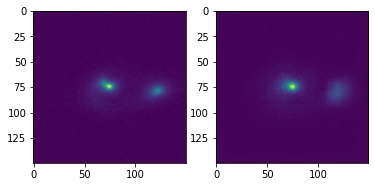

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 67/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 68/100: 100%|██████████| 71/71 [00:19<00:00,  3.65it/s]


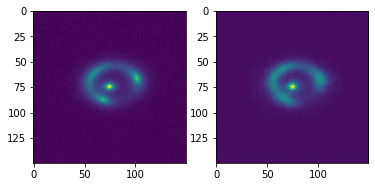

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 68/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 69/100: 100%|██████████| 71/71 [00:19<00:00,  3.57it/s]


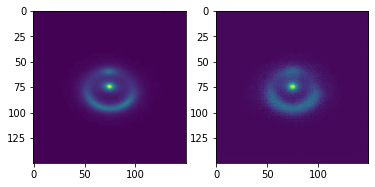

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 69/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 70/100: 100%|██████████| 71/71 [00:20<00:00,  3.55it/s]


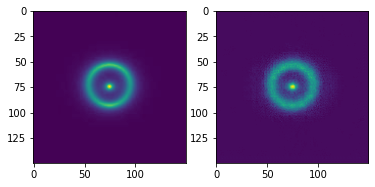

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 70/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 71/100: 100%|██████████| 71/71 [00:19<00:00,  3.63it/s]


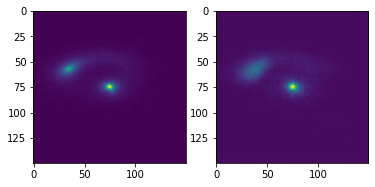

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 71/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 72/100: 100%|██████████| 71/71 [00:19<00:00,  3.62it/s]


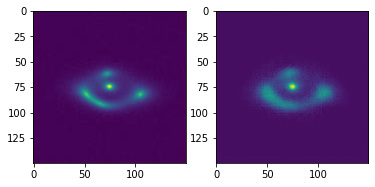

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 72/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 73/100: 100%|██████████| 71/71 [00:19<00:00,  3.62it/s]


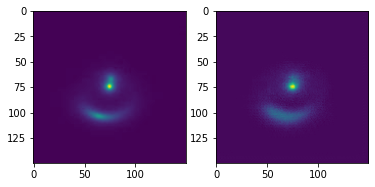

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 73/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 74/100: 100%|██████████| 71/71 [00:19<00:00,  3.57it/s]


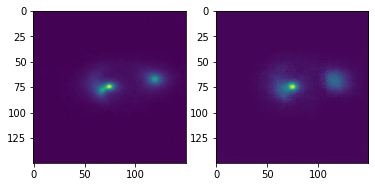

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 74/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 75/100: 100%|██████████| 71/71 [00:19<00:00,  3.61it/s]


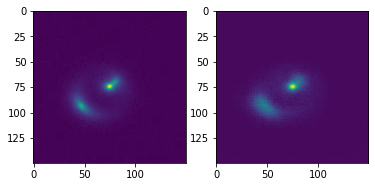

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 75/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 76/100: 100%|██████████| 71/71 [00:19<00:00,  3.58it/s]


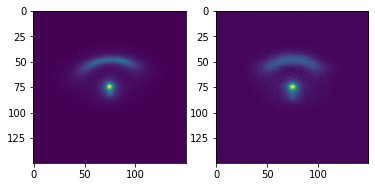

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 76/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 77/100: 100%|██████████| 71/71 [00:19<00:00,  3.62it/s]


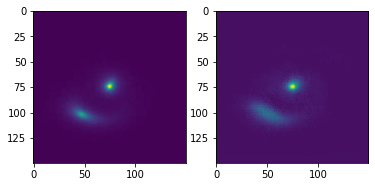

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 77/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 78/100: 100%|██████████| 71/71 [00:20<00:00,  3.52it/s]


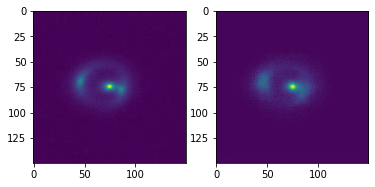

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 78/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 79/100: 100%|██████████| 71/71 [00:19<00:00,  3.57it/s]


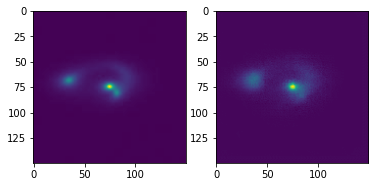

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 79/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 80/100: 100%|██████████| 71/71 [00:19<00:00,  3.55it/s]


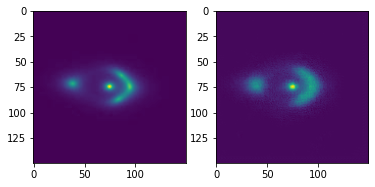

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 80/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 81/100: 100%|██████████| 71/71 [00:20<00:00,  3.55it/s]


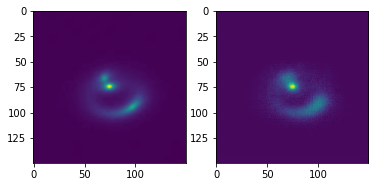

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 81/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 82/100: 100%|██████████| 71/71 [00:20<00:00,  3.55it/s]


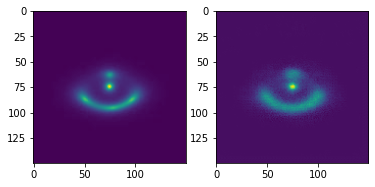

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 82/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 83/100: 100%|██████████| 71/71 [00:20<00:00,  3.49it/s]


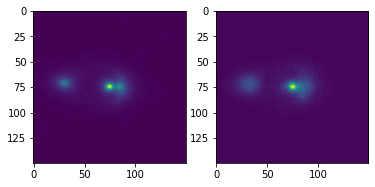

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 83/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 84/100: 100%|██████████| 71/71 [00:20<00:00,  3.50it/s]


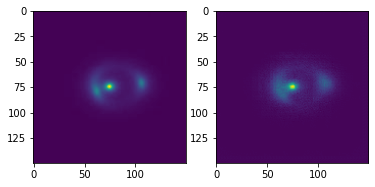

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 84/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 85/100: 100%|██████████| 71/71 [00:20<00:00,  3.51it/s]


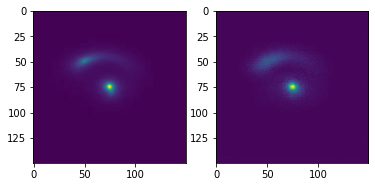

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 85/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 86/100: 100%|██████████| 71/71 [00:20<00:00,  3.42it/s]


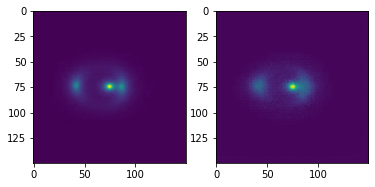

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 86/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 87/100: 100%|██████████| 71/71 [00:20<00:00,  3.47it/s]


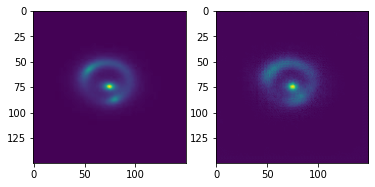

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 87/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 88/100: 100%|██████████| 71/71 [00:20<00:00,  3.43it/s]


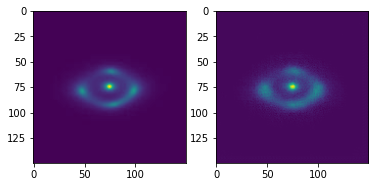

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 88/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 89/100: 100%|██████████| 71/71 [00:20<00:00,  3.50it/s]


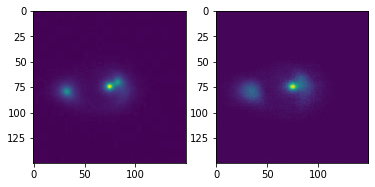

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 89/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 90/100: 100%|██████████| 71/71 [00:20<00:00,  3.51it/s]


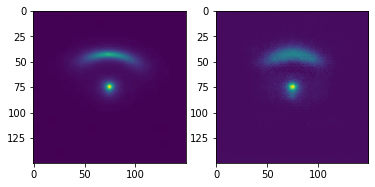

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 90/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 91/100: 100%|██████████| 71/71 [00:20<00:00,  3.51it/s]


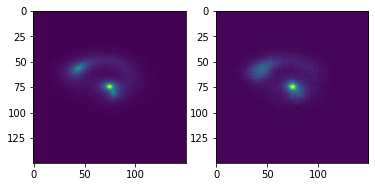

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 91/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 92/100: 100%|██████████| 71/71 [00:20<00:00,  3.48it/s]


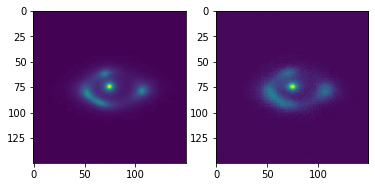

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 92/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 93/100: 100%|██████████| 71/71 [00:20<00:00,  3.44it/s]


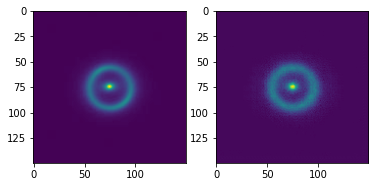

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 93/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 94/100: 100%|██████████| 71/71 [00:20<00:00,  3.46it/s]


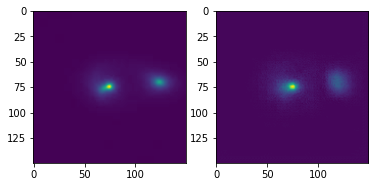

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 94/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 95/100: 100%|██████████| 71/71 [00:20<00:00,  3.47it/s]


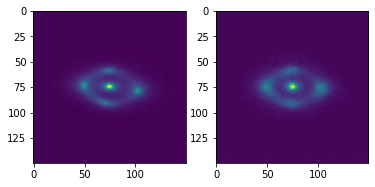

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 95/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 96/100: 100%|██████████| 71/71 [00:20<00:00,  3.46it/s]


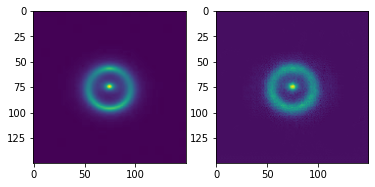

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 96/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 97/100: 100%|██████████| 71/71 [00:20<00:00,  3.44it/s]


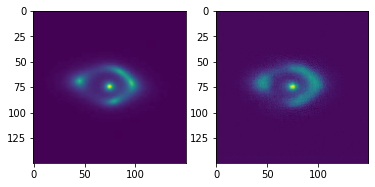

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 97/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 98/100: 100%|██████████| 71/71 [00:20<00:00,  3.44it/s]


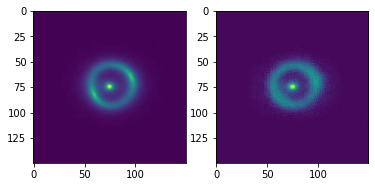

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 98/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 99/100: 100%|██████████| 71/71 [00:21<00:00,  3.38it/s]


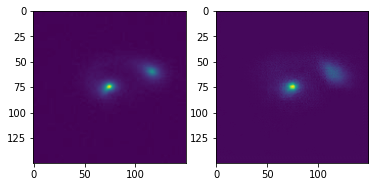

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 99/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 100/100: 100%|██████████| 71/71 [00:20<00:00,  3.42it/s]


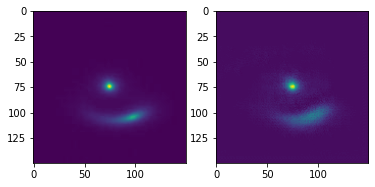


[Epoch 100/100] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


In [248]:
save_path_scratch = os.path.join('/content/drive/MyDrive/ml4sci/domain_adaptation/', 'weights_history_scratch.pt')

encoder_scratch, decoder_scratch, discriminator_scratch, history_scratch = train_model(encoder_scratch, decoder_scratch, discriminator_scratch, train_no_sub_dataloader, 100, save_path_scratch, viz=True)

## 3.1 Visualizing the training metrics

We'll now load the model and the history and visualize the training metrics. Note that it isn't necessary to load the model and the training history since we already have it. But this could be useful in case the runtime crashes.

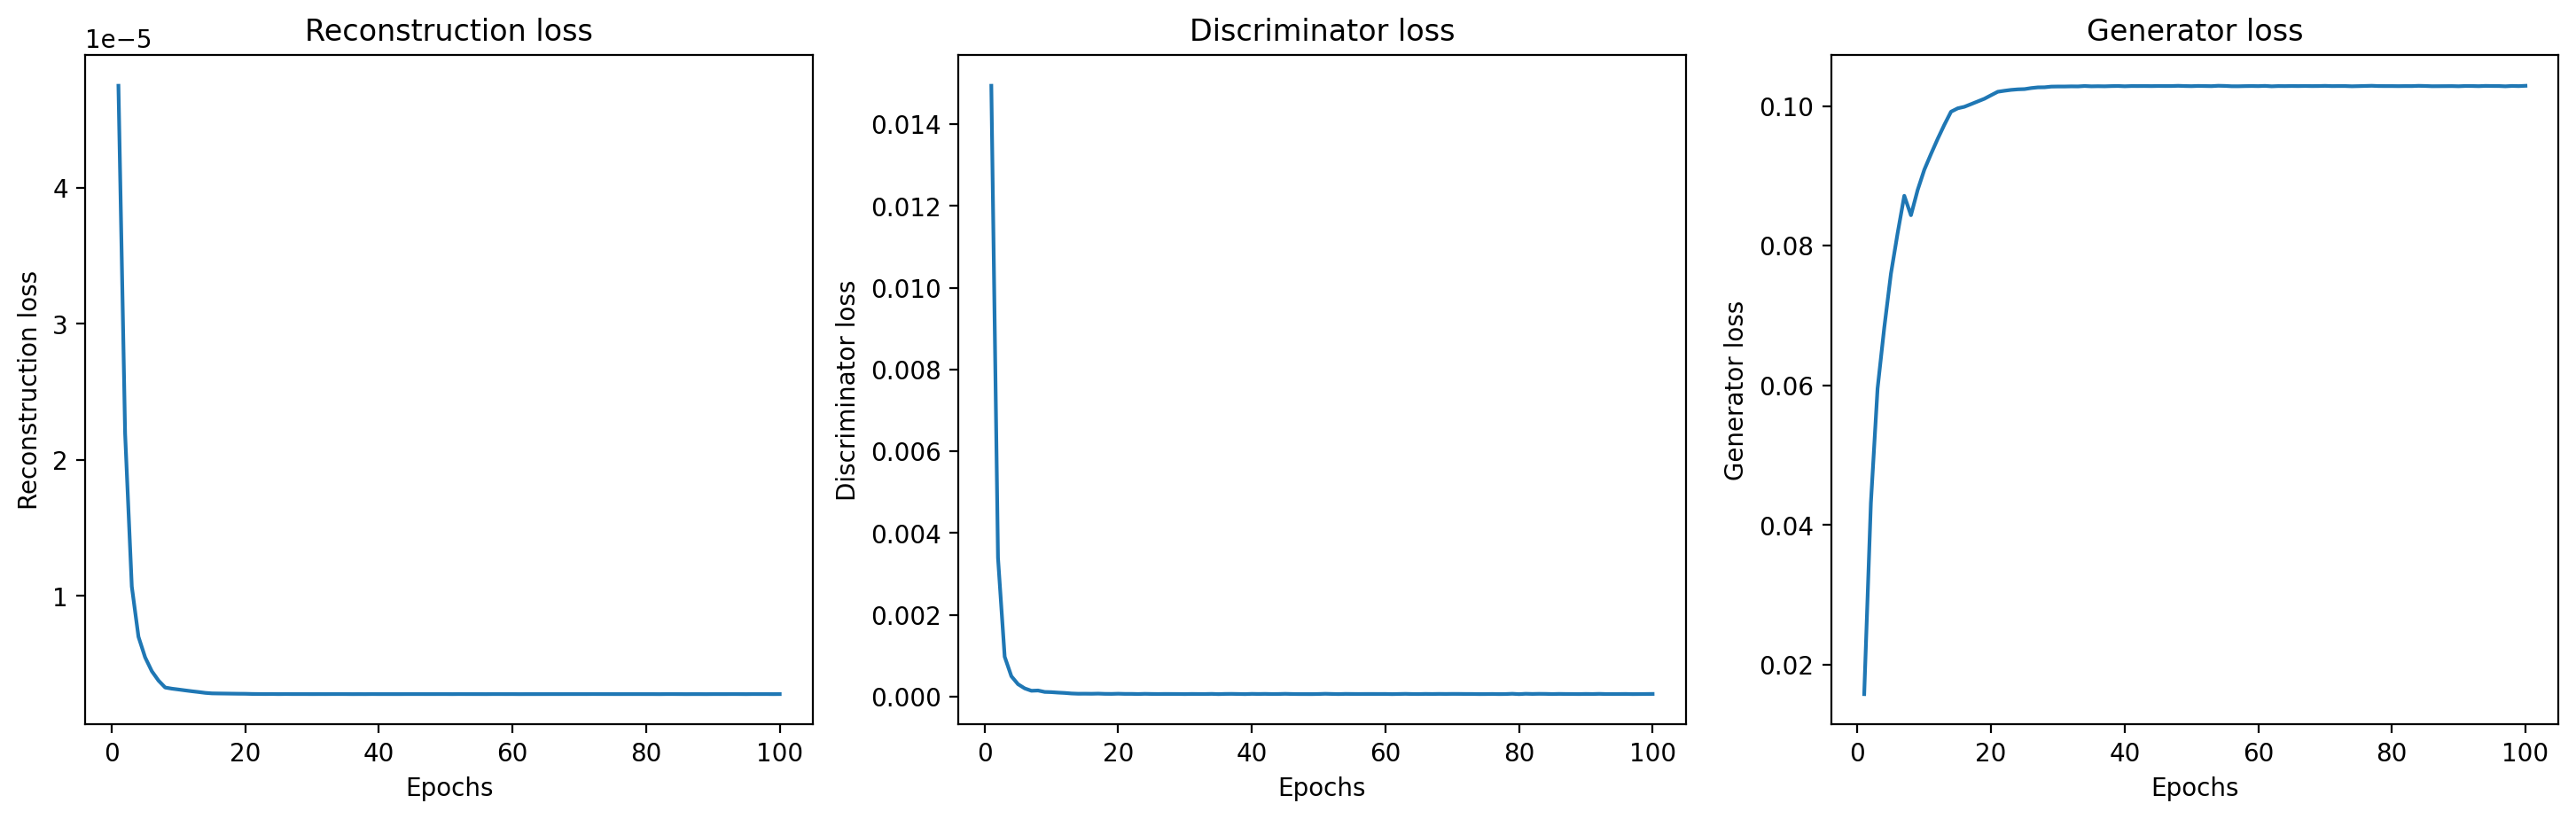

In [249]:
encoder_scratch, decoder_scratch, discriminator_scratch, history_scratch = load_weights_and_history(save_path_scratch)
metrics(history_scratch)

## 3.2 Evaluating the model

Now, finally, we'll evaluate the model on the testing set that we defined earlier:

  0%|          | 0/9000 [00:00<?, ?it/s]


finding anomaly_scores statistics...


100%|██████████| 9000/9000 [00:51<00:00, 173.58it/s]


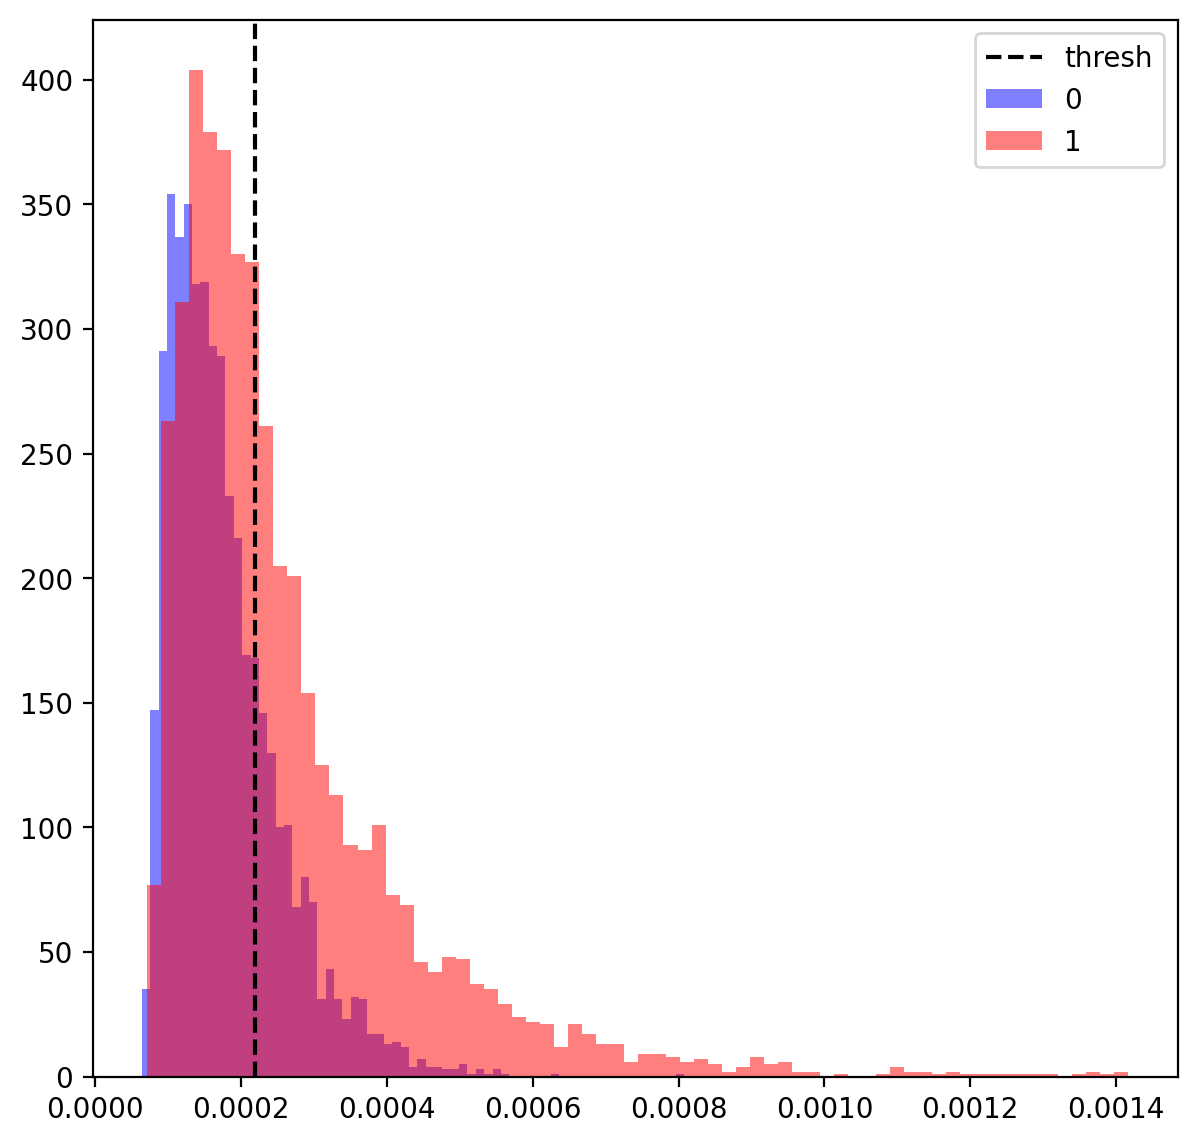

0.0002193083031169307

In [276]:
thresh_scratch = find_thresh(encoder_scratch, decoder_scratch, discriminator_scratch, train_all_dataloader, viz=True)
thresh_scratch

100%|██████████| 1000/1000 [00:04<00:00, 235.25it/s]


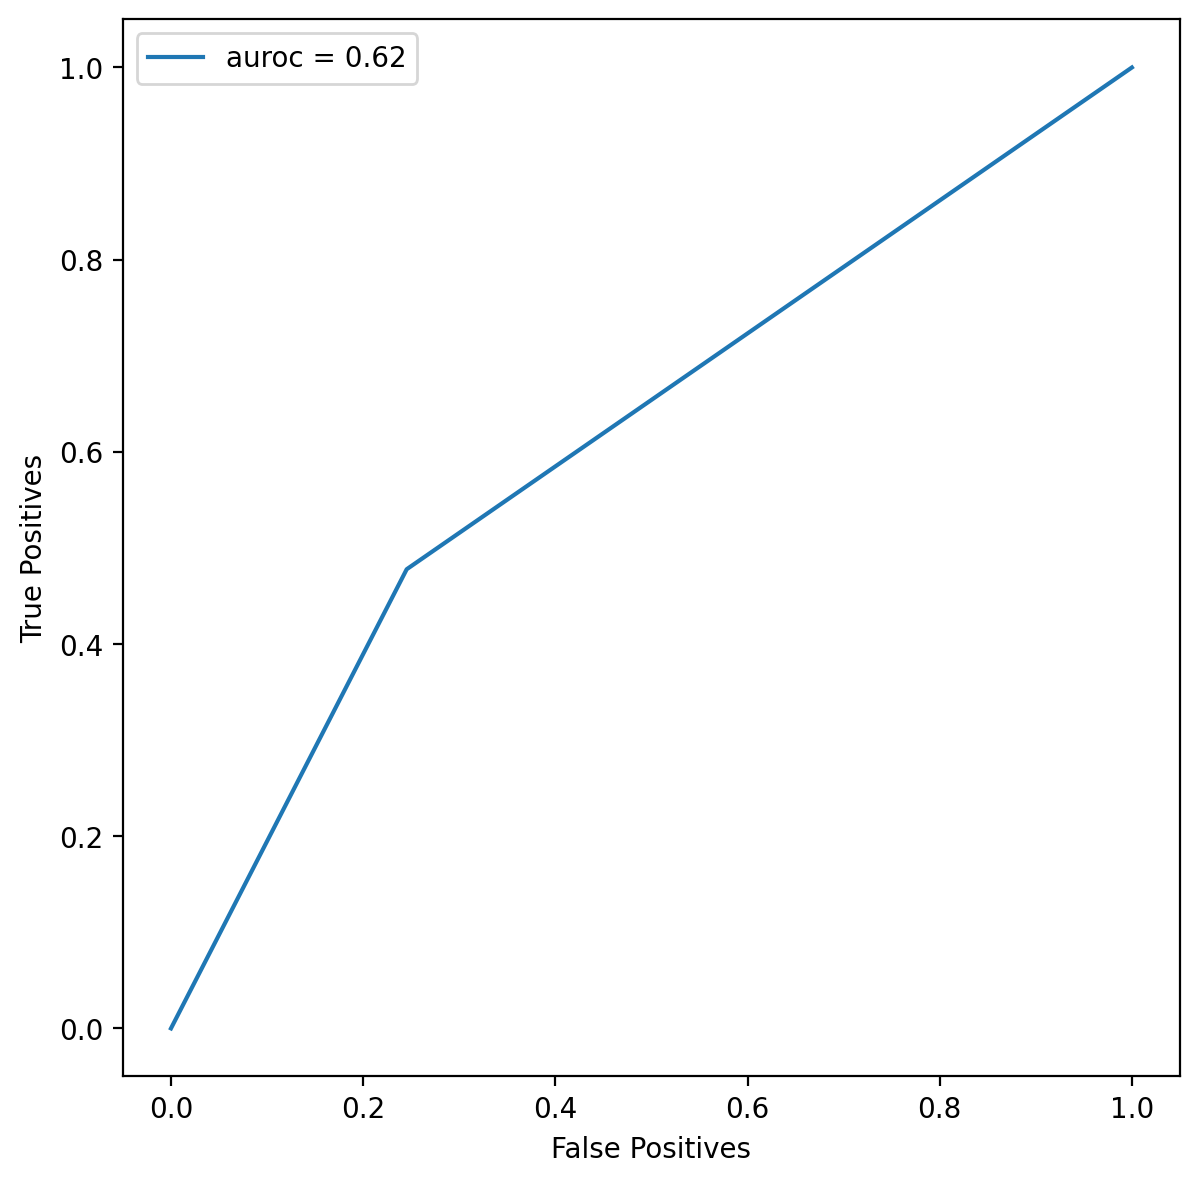

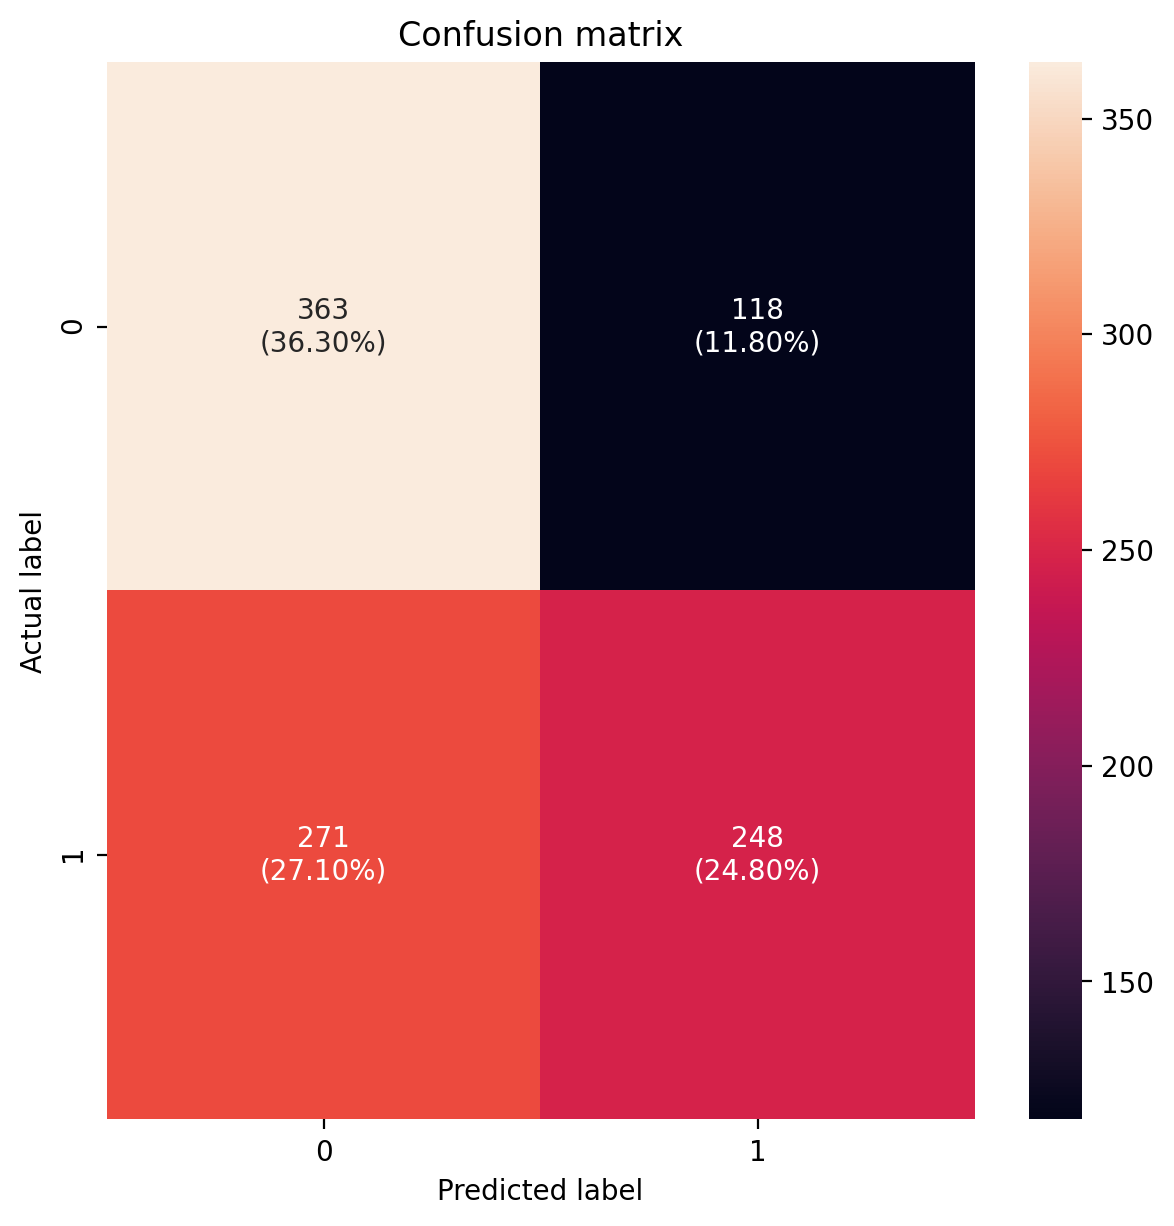

In [277]:
dec_list = evaluate(encoder_scratch, decoder_scratch, discriminator_scratch, test_dataloader, thresh_scratch)

# 4. Using a pre-trained AAE as a feature extractor

## 4.0 Loading the pre-trained model

We'll first load the weights for each "sub-model":

In [252]:
encoder_weights = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/Model_Weights/AAE_Encoder.pth'
decoder_weights = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/Model_Weights/AAE_Decoder.pth'
discriminator_weights = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/Model_Weights/AAE_Discriminator.pth'

encoder_fe, decoder_fe, discriminator_fe = load_model_pretrained(encoder_weights, decoder_weights, discriminator_weights)

## 4.1 Evaluating

Instead of training this model, we'll just use it as is. According to the evaluation test, the model that we just loaded was trained only on images of strong gravitational lenses without substructure, i.e. `no_sub` labels. By making this model fixed, we can use the fact that it doesn't know how to handle `sub` images and use the model as an anomaly detector:

  0%|          | 0/9000 [00:00<?, ?it/s]


finding anomaly_scores statistics...


100%|██████████| 9000/9000 [00:51<00:00, 175.40it/s]


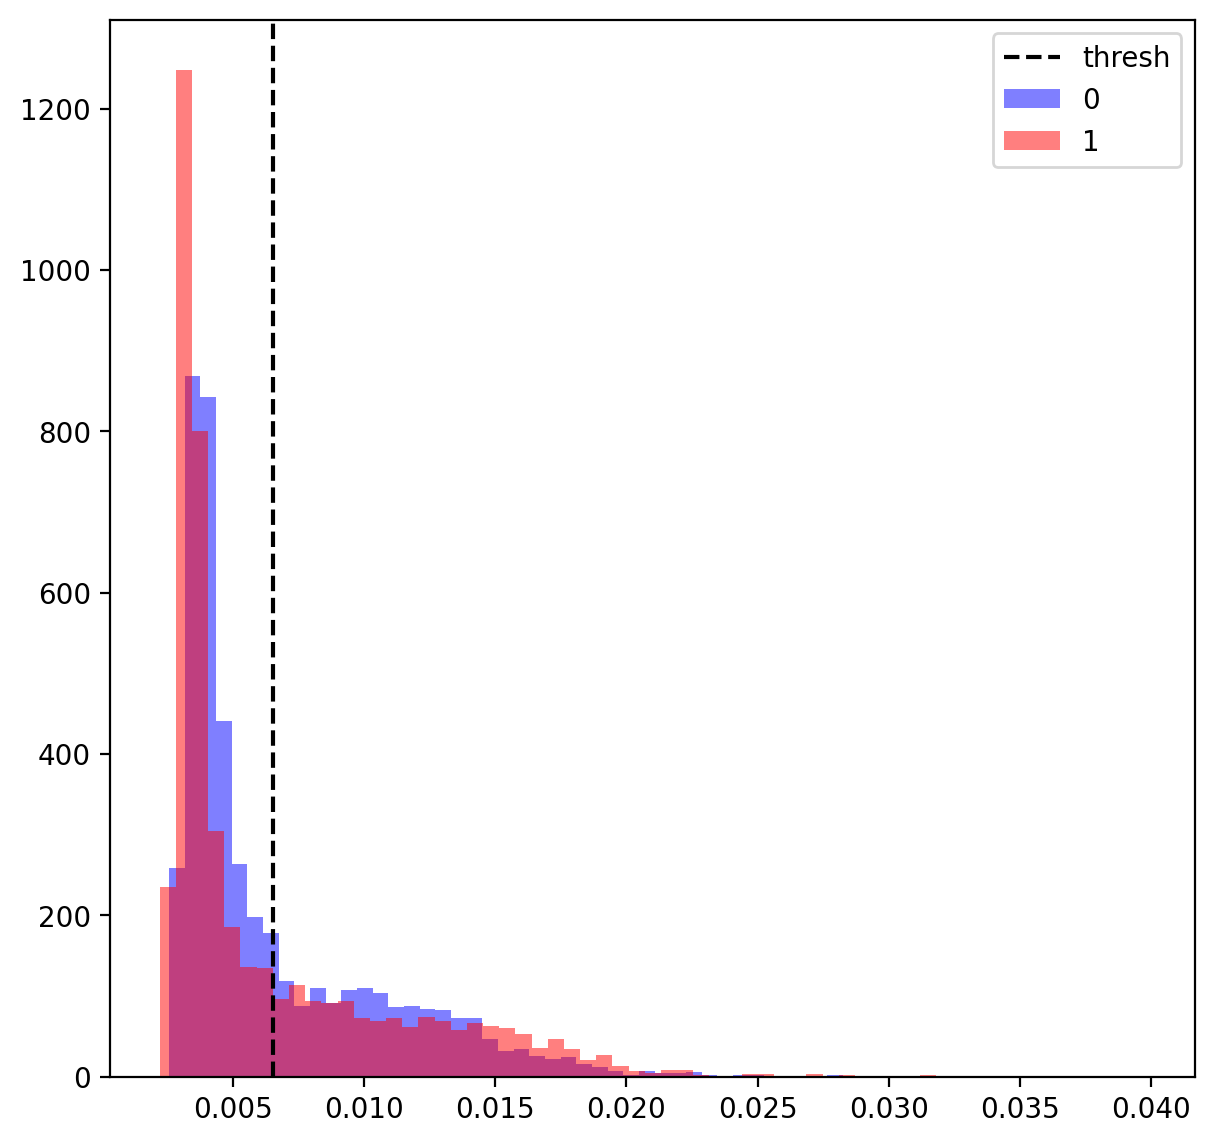

0.00653665763936523

In [278]:
thresh_fe = find_thresh(encoder_fe, decoder_fe, discriminator_fe, train_all_dataloader, viz=True)
thresh_fe

100%|██████████| 1000/1000 [00:04<00:00, 225.18it/s]


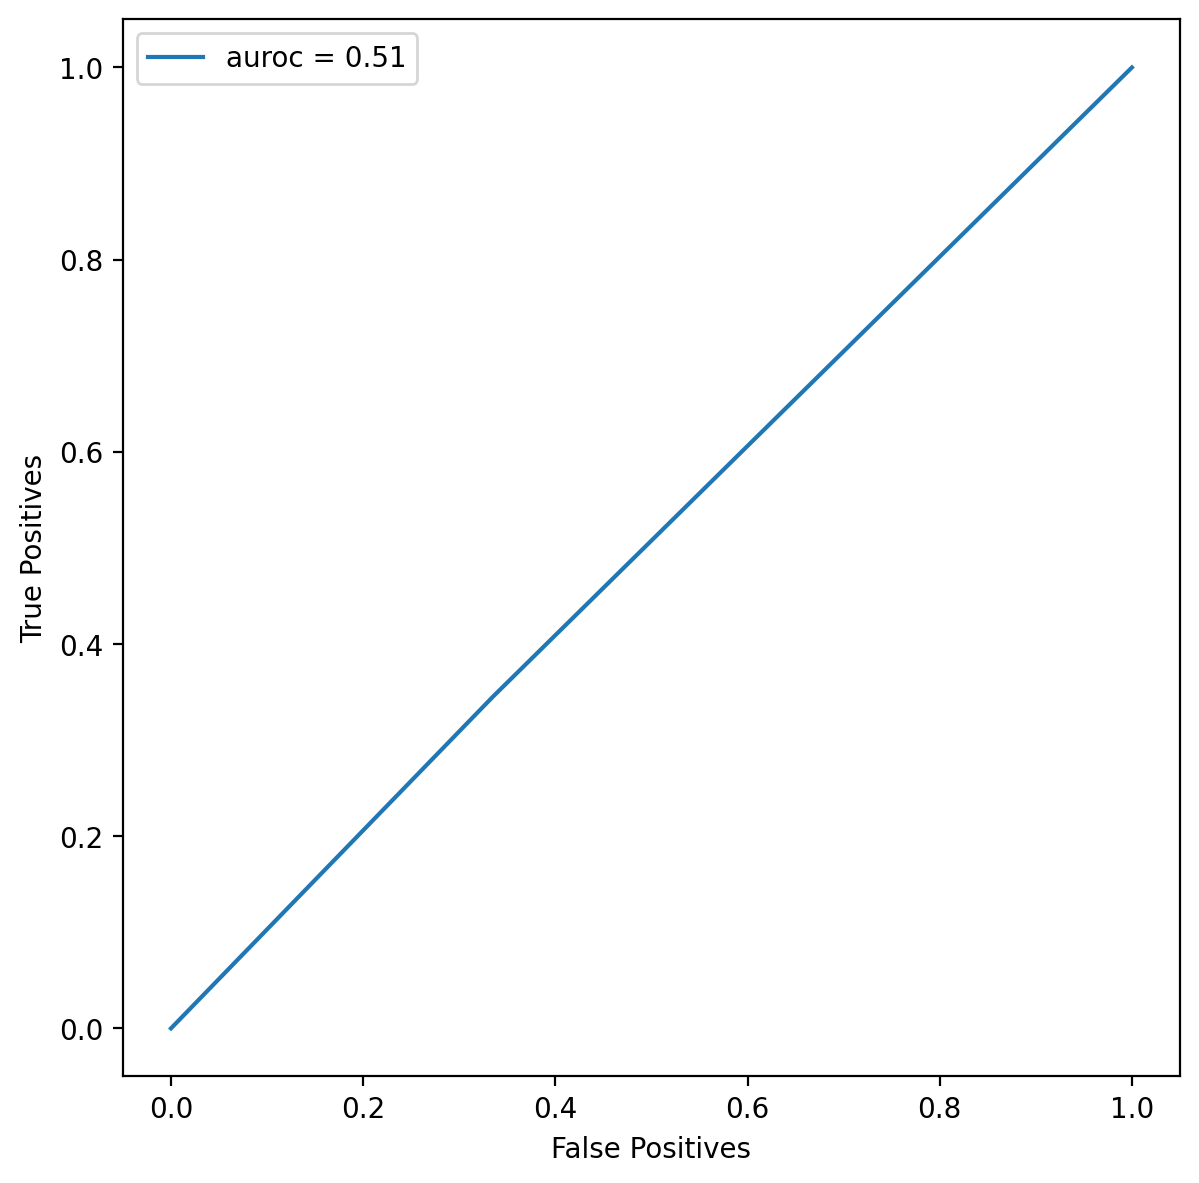

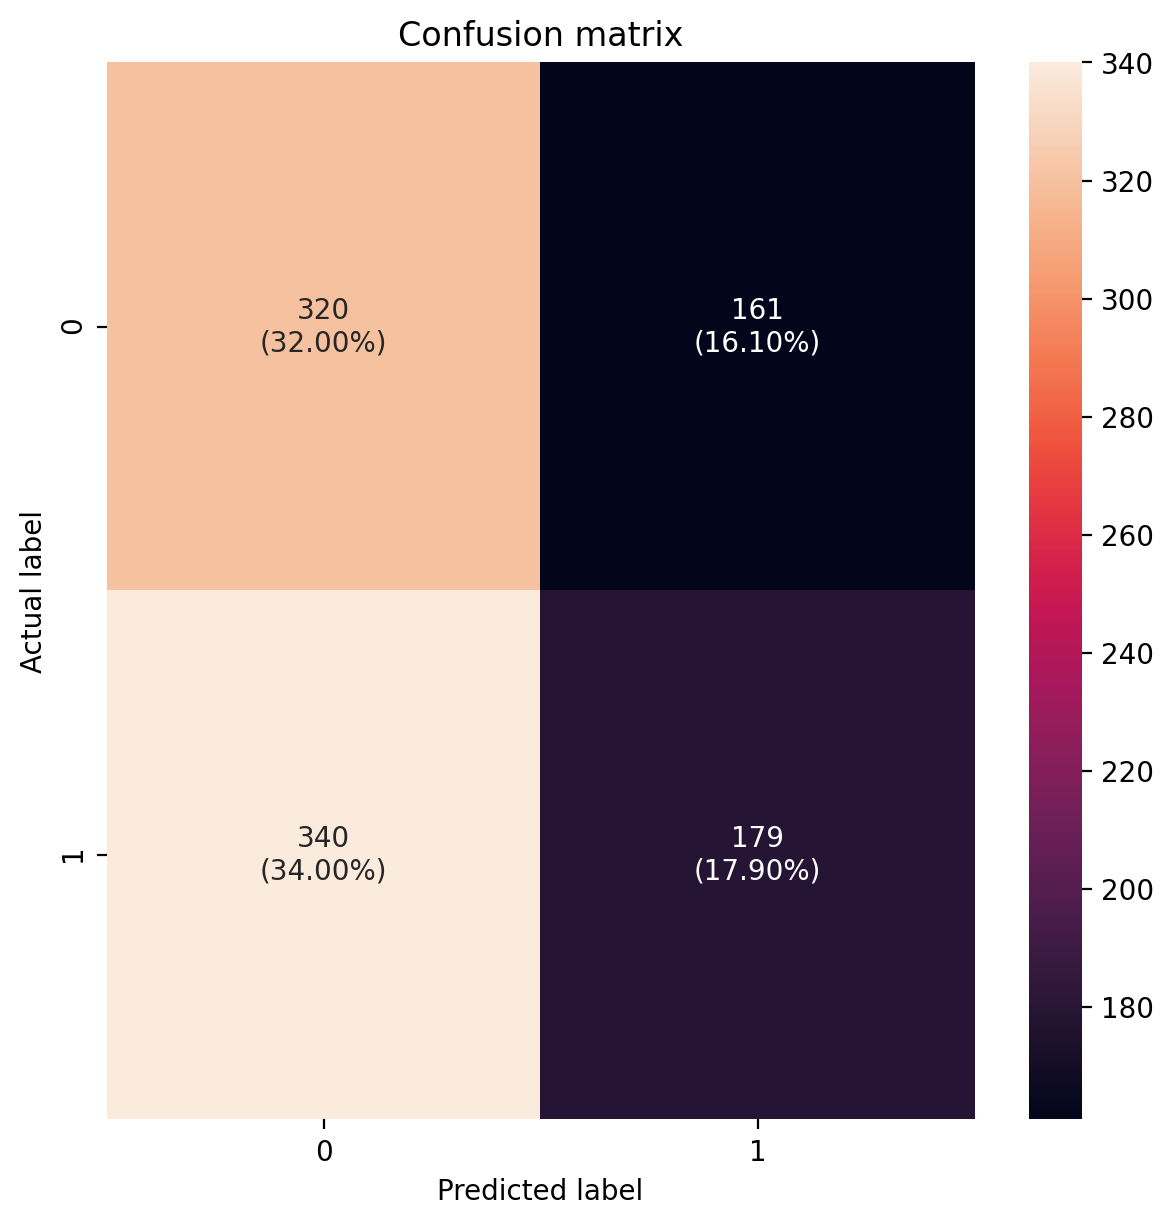

In [279]:
evaluate(encoder_fe, decoder_fe, discriminator_fe, test_dataloader, thresh_fe)

# 5. Finetuning a pre-trained AAE

## 5.0 Loading the pre-trained model

We'll load the weights for each "sub-model":

In [255]:
encoder_weights = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/Model_Weights/AAE_Encoder.pth'
decoder_weights = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/Model_Weights/AAE_Decoder.pth'
discriminator_weights = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/Model_Weights/AAE_Discriminator.pth'

encoder_ft, decoder_ft, discriminator_ft = load_model_pretrained(encoder_weights, decoder_weights, discriminator_weights)

## 5.1 Training the model

We'll perform training just like we did with the AAE from scratch. The only difference is that now we begin with the pre-trained weights:

In [256]:
save_path_ft = os.path.join('/content/drive/MyDrive/ml4sci/domain_adaptation/', 'weights_history_ft.pt')
encoder_ft, decoder_ft, discriminator_ft, history_ft = train_model(encoder_ft, decoder_ft, discriminator_ft, train_no_sub_dataloader, 100, save_path_ft, viz=False)

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 1/100] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3598


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 2/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.2834


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 3/100] reconstruction loss: 0.0000; discriminator loss: 0.0009; generator loss: 0.3024


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 4/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3119


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 5/100] reconstruction loss: 0.0000; discriminator loss: 0.0009; generator loss: 0.3268


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 6/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3335


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 7/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3321


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 8/100] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3282


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 9/100] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3257


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 10/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3232


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 11/100] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3260


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 12/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3253


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 13/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3232


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 14/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3241


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 15/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3263


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 16/100] reconstruction loss: 0.0000; discriminator loss: 0.0003; generator loss: 0.3261


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 17/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3241


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 18/100] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3230


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 19/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3234


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 20/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3244


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 21/100] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3240


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 22/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3232


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 23/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3226


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 24/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3227


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 25/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3236


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 26/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3235


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 27/100] reconstruction loss: 0.0000; discriminator loss: 0.0003; generator loss: 0.3240


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 28/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3226


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 29/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3229


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 30/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3234


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 31/100] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3227


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 32/100] reconstruction loss: 0.0000; discriminator loss: 0.0008; generator loss: 0.3237


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 33/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3238


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 34/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3223


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 35/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3222


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 36/100] reconstruction loss: 0.0000; discriminator loss: 0.0008; generator loss: 0.3233


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 37/100] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3223


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 38/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3238


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 39/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3236


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 40/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3240


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 41/100] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3234


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 42/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3237


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 43/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3231


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 44/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3233


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 45/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3219


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 46/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3233


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 47/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3226


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 48/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3230


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 49/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3227


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 50/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3221


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 51/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3238


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 52/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3231


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 53/100] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3232


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 54/100] reconstruction loss: 0.0000; discriminator loss: 0.0003; generator loss: 0.3231


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 55/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3235


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 56/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3228


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 57/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3227


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 58/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3229


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 59/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3224


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 60/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3241


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 61/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3221


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 62/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3233


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 63/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3225


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 64/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3232


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 65/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3243


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 66/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3232


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 67/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3230


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 68/100] reconstruction loss: 0.0000; discriminator loss: 0.0008; generator loss: 0.3232


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 69/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3233


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 70/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3234


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 71/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3224


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 72/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3235


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 73/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3221


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 74/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3231


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 75/100] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3231


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 76/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3241


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 77/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3232


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 78/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3224


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 79/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3225


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 80/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3230


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 81/100] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3228


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 82/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3232


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 83/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3221


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 84/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3235


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 85/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3225


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 86/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3231


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 87/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3234


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 88/100] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3227


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 89/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3243


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 90/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3233


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 91/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3226


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 92/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3241


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 93/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3227


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 94/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3228


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 95/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3218


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 96/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3235


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 97/100] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3230


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 98/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3232


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 99/100] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3225


Epoch 100/100: 100%|██████████| 71/71 [00:18<00:00,  3.94it/s]


[Epoch 100/100] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3232


## 5.2 Visualizing the training metrics

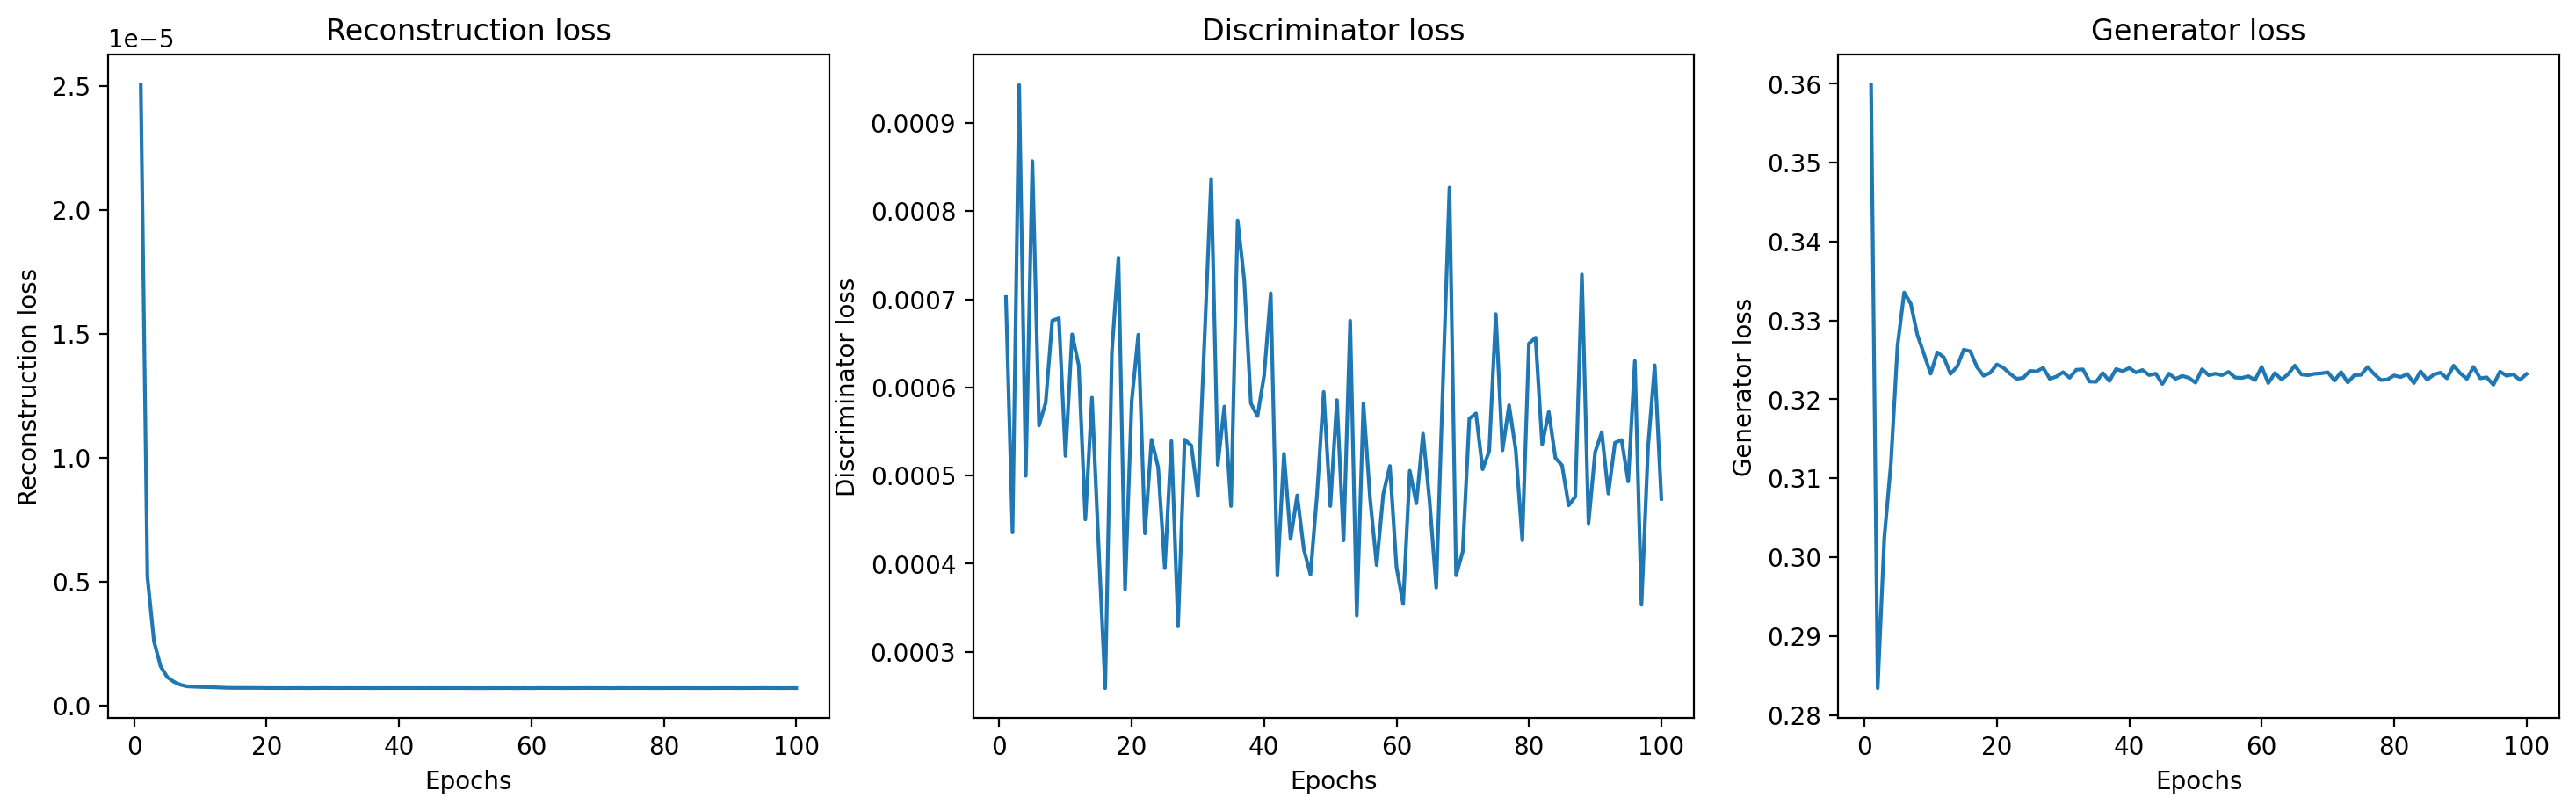

In [257]:
encoder_ft, decoder_ft, discriminator_ft, history_ft = load_weights_and_history(save_path_ft)
metrics(history_ft)

## 5.3 Evaluating the model

  0%|          | 0/9000 [00:00<?, ?it/s]


finding anomaly_scores statistics...


100%|██████████| 9000/9000 [00:51<00:00, 174.25it/s]


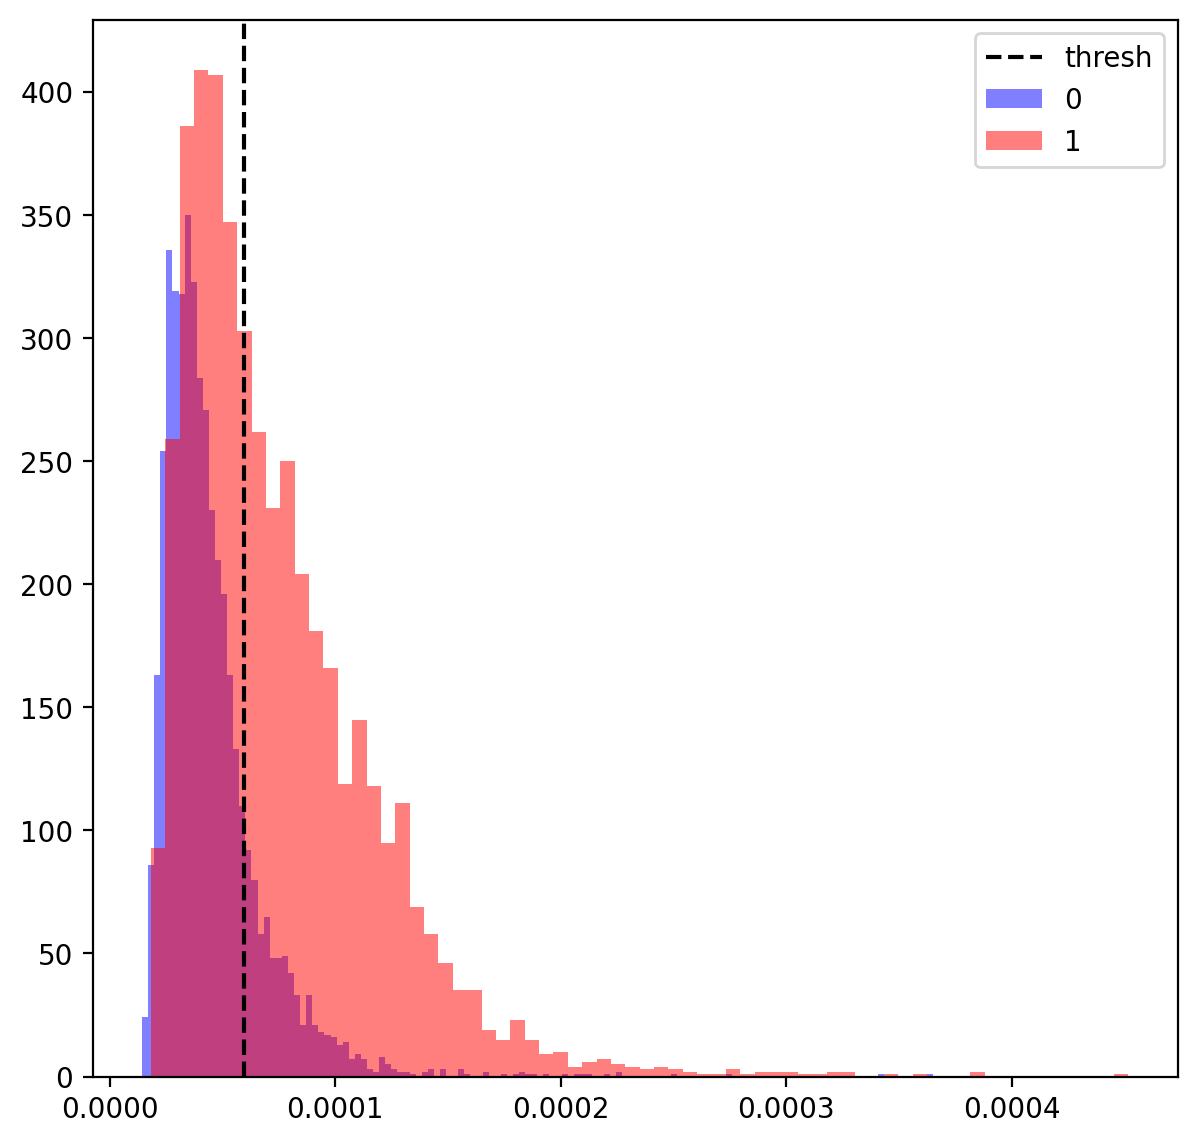

5.976126192045841e-05

In [280]:
thresh_ft = find_thresh(encoder_ft, decoder_ft, discriminator_ft, train_all_dataloader, viz=True)
thresh_ft

100%|██████████| 1000/1000 [00:04<00:00, 229.07it/s]


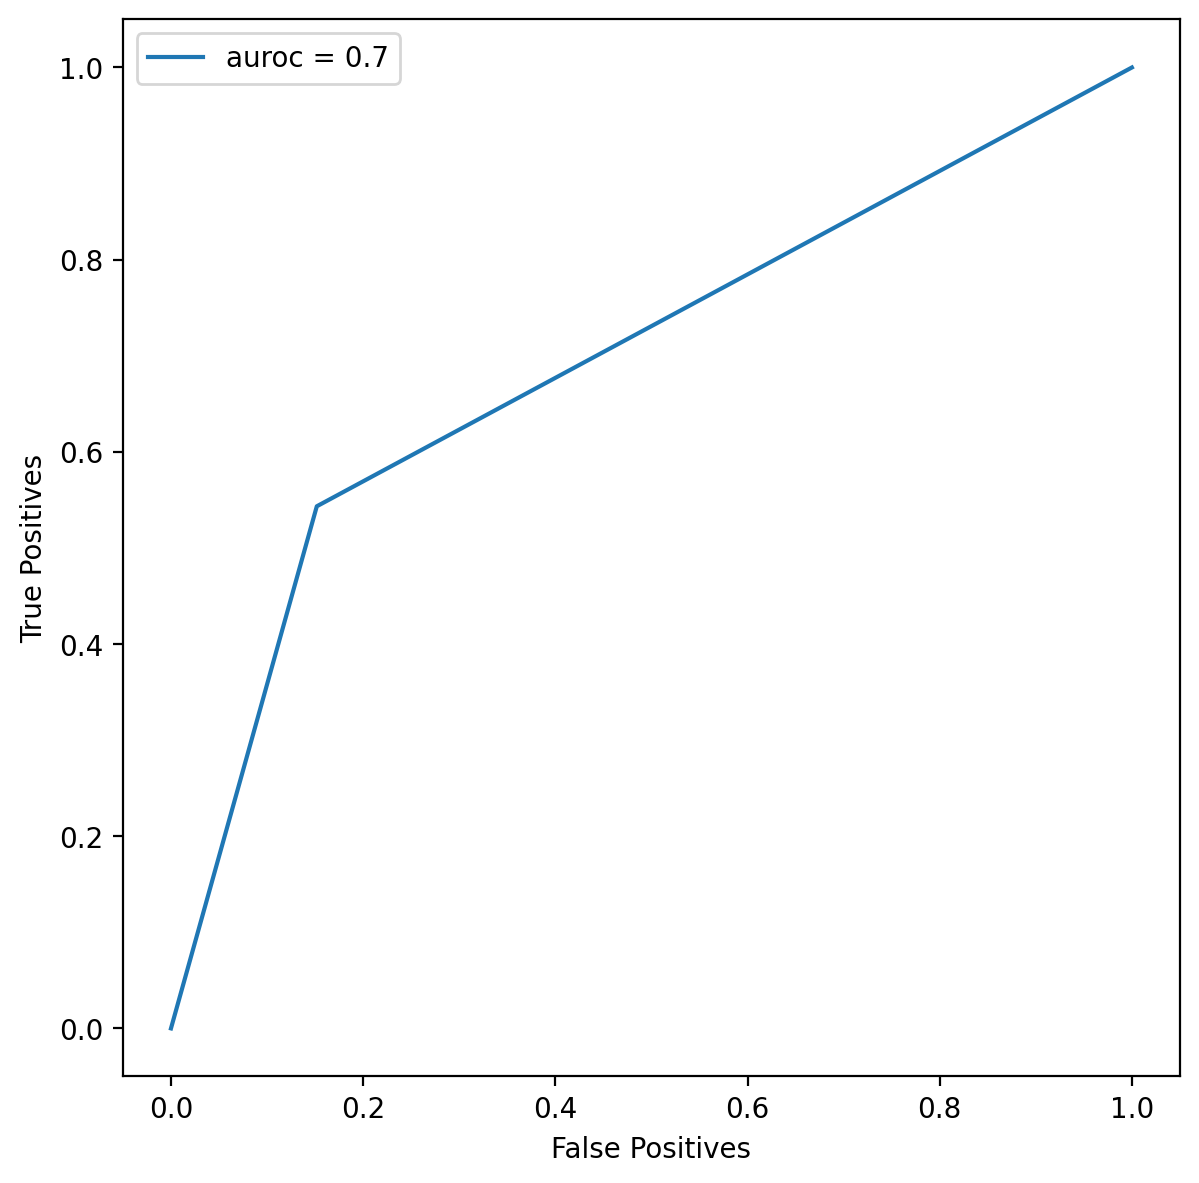

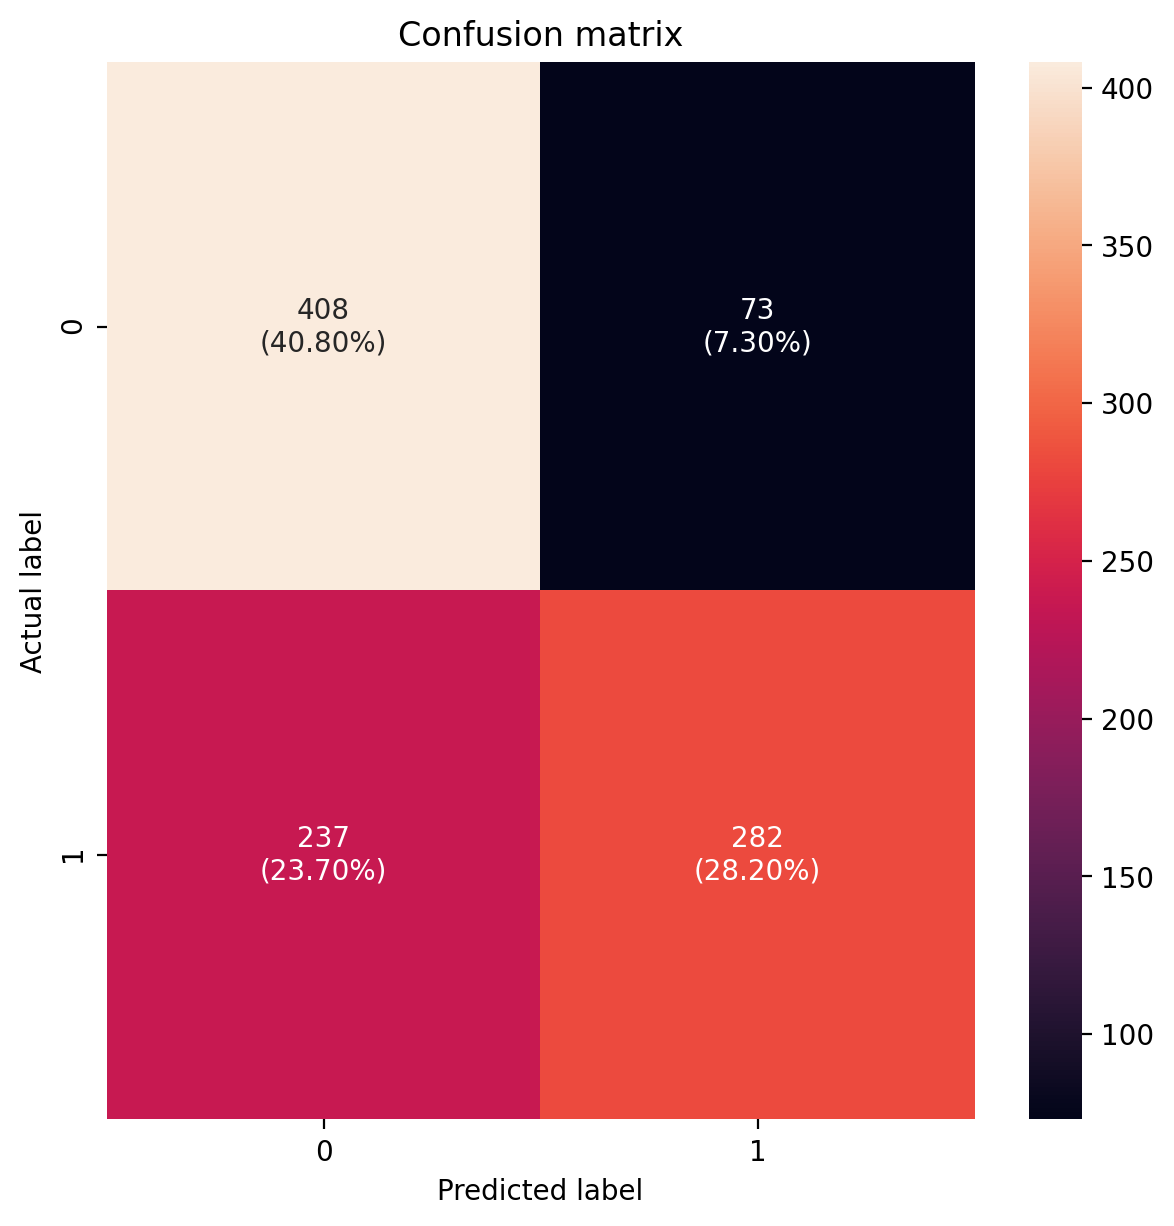

In [281]:
evaluate(encoder_ft, decoder_ft, discriminator_ft, test_dataloader, thresh_ft)

# 6. Next steps

A good next step would be, of course, to test other hyperparameters. Since there are so many different possibilities in an Adversarial Autoencoder architecture (different learning rates, different schedulers for each learning rate, different optimizers, different epochs) this would probably take a while! Nevertheless, it's an important step when searching for the best performance.

Another pretty useful thing would be to check different distributions. I used a very basic normal distribution with mean $0$ and variance $1$. Other more complex distributions could be tested, such as the one seen [here](https://github.com/GitiHubi/deepAD/blob/master/KDD_2019_Lab.ipynb). Also related to distributions, searching for a better way of finding `thresh` would be really useful. Checking the distributions of samples I think that maybe something related to the mode of each label could work out.

I tested both mean and median and found better AUROC scores using the mean over all anomaly scores. We can see, however in the confusion matrices that using this the model "prefers" to classify images as class 1 (`sub`). With this, the model while complete isn't pure.

Finally, a class implementation of the AAE "instantiating-loading weights-training-visualizing metrics-evaluating pipeline" would be especially useful to let this work be more reproducible. A concept of how this implementation could be made and used can be seen in my first submission [here](https://github.com/zysymu/ml4sci/blob/main/domain_adaptation/domain_adaptation.ipynb). Note that the results are pretty bad in this implementation for lots of reasons, it's just a way of showing a possible structure.

# REFERENCES:

- https://github.com/DeepLense-Unsupervised/unsupervised-lensing
- https://arxiv.org/pdf/1908.00734.pdf
- https://arxiv.org/pdf/2008.12731.pdf
- https://arxiv.org/pdf/1902.06924.pdf
- https://github.com/fducau/AAE_pytorch
- https://towardsdatascience.com/a-wizards-guide-to-adversarial-autoencoders-part-2-exploring-latent-space-with-adversarial-2d53a6f8a4f9
- https://blog.paperspace.com/adversarial-autoencoders-with-pytorch/
- https://github.com/bfarzin/pytorch_aae
- https://github.com/sksq96/pytorch-vae
- https://github.com/neale/Adversarial-Autoencoder
- https://github.com/shaharazulay/adversarial-autoencoder-classifier